# Airnb Amenity Detection

## Import modules

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch, torchvision
import detectron2

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger() # this logs Detectron2 information such as what the model is doing when it's training

# import some common libraries
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cv2
import random

# Initialize Weights & Biases
import wandb


# import custom libraries
#from modules.preprocessing import *
from modules.train import *

# import some common detectron2 utilities
from detectron2.structures import BoxMode
from detectron2 import model_zoo # a series of pre-trained Detectron2 models: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md
from detectron2.engine import DefaultPredictor # a default predictor class to make predictions on an image using a trained model
from detectron2.config import get_cfg # a config of "cfg" in Detectron2 is a series of instructions for building a model
from detectron2.utils.visualizer import Visualizer # a class to help visualize Detectron2 predictions on an image
from detectron2.data import DatasetCatalog, MetadataCatalog # stores information about the model such as what the training/test data is, what the class names are

## Custom Model

##### Try Detecron 2 on Custom Dataset

Before jumping onto model building, try it on small dataset (probaly on single) and make sure it is working as expected

### Data Preparation

In [3]:
# Change Dirrectory to DataSets directory

if 'DataSets' not in os.getcwd():
    os.chdir('DataSets')
os.getcwd()

'/home/santhosh/HardDisk/skumar/DataScience/Projects_Section/Projects_Working/Airbnb_Amenity_Detection/DataSets'

Define list of classes selected for amenity detection

In [4]:
# Target classes
target_classes = [
    "Toilet", "Swimming_pool", "Bed", "Billiard_table", "Sink", "Fountain",
    "Oven", "Ceiling_fan", "Television", "Microwave_oven", "Gas_stove",
    "Refrigerator", "Kitchen_&_dining_room_table", "Washing_machine",
    "Bathtub", "Stairs", "Fireplace", "Pillow", "Mirror", "Shower", "Couch",
    "Countertop", "Coffeemaker", "Dishwasher", "Sofa_bed", "Tree_house",
    "Towel", "Porch", "Wine_rack", "Jacuzzi"
]

In [5]:
from pdb import set_trace
def annote_image(annotations, resize=False):
    file_name = annotations.file_name.to_numpy()[0]
    
    img = cv2.cvtColor(cv2.imread(f'{file_name}'), 
                       cv2.COLOR_BGR2RGB)
    for a in annotations.annotations[0]:
        xxyy = [int(i) for i in a['bbox']]
        cv2.rectangle(img, (xxyy[0],xxyy[1]),(xxyy[2],xxyy[3]), (0,255,0), 2)
    
    if not resize:
        return img
    
    return cv2.resize(img, (384,384), interpolation = cv2.INTER_AREA)

In [8]:
!pwd

/home/santhosh/HardDisk/skumar/DataScience/Projects_Section/Projects_Working/Airbnb_Amenity_Detection/DataSets


**prepare the Dataset**

Register our dataset to detectron2, following the detectron2 custom dataset tutorial.

Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. See the tutorial for more details.

### Label generator

In [5]:
def get_image_ids(image_folder=None):
    """
    Explores a folder of images and gets their ID from their file name.
    Returns a list of all image ID's in image_folder.
    E.g. image_folder/608fda8c976e0ac.jpg -> ["608fda8c976e0ac"]
    
    Params
    ------
    image_folder (str): path to folder of images, e.g. "../validation/"
    """
    return [os.path.splitext(img_name)[0] for img_name in os.listdir(image_folder) if img_name.endswith(".jpg")]

# Make a function which formats a specific annotations csv based on what we're dealing with
def format_annotations(image_folder, annotation_file, target_classes=None):
    """
    TODO - NOTE: This function could (definitely can) be faster.
    TODO - Some ideas: skip the use of pandas entirely and use CSV's
    
    Formats annotation_file based on images contained in image_folder.
    Will get all unique image IDs and make sure annotation_file
    only contains those (the target images).
    Adds meta-data to annotation_file such as class names and categories.
    If target_classes isn't None, the returned annotations will be filtered by this list.
    Note: image_folder and annotation_file should both be validation if working on
    validation set or both be training if working on training set.
    
    Params
    ------
    image_folder (str): path to folder of target images.
    annotation_file (str): path to annotation file of target images.
    target_classes (list), optional: a list of target classes you'd like to filter labels.
    """
    # Get all image ids from target directory
    image_ids = get_image_ids(image_folder)
    
    # Setup annotation file and classnames
    # TODO - improve this, is pandas required? 
    annot_file = pd.read_csv(annotation_file)
    classes = pd.read_csv("class-descriptions-boxable.csv",
                          names=["LabelName", "ClassName"])
    
    # Create classname column on annotations which converts label codes to string labels
    annot_file["ClassName"] = annot_file["LabelName"].map(classes.set_index("LabelName")["ClassName"])

    # Sort annot_file by "ClassName" for alphabetical labels (used with target_classes)
    annot_file.sort_values(by=["ClassName"], inplace=True)
    
    # TODO - fix this, Make sure we only get the images we're concerned about
    if target_classes:
        annot_file = annot_file[annot_file["ImageID"].isin(image_ids) & annot_file["ClassName"].isin(target_classes)]
    else:
        annot_file = annot_file[annot_file["ImageID"].isin(image_ids)]
   
    # Add ClassID column, e.g. "Bathtub, Toilet" -> 1, 2
    annot_file["ClassName"] = pd.Categorical(annot_file["ClassName"])
    annot_file["ClassID"] = annot_file["ClassName"].cat.codes
    
    return annot_file

def rel_to_absolute(bbox, height, width):
    """
    Converts bounding box dimensions from relative to absolute pixel values (Detectron2 style).
    See: https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.BoxMode
    
    Params
    ------
    bbox (array): relative dimensions of bounding box in format (x0, y0, x1, y1 or Xmin, Ymin, Xmax, Ymax)
    height (int): height of image
    width (int): width of image
    """
    bbox[0] = np.round(np.multiply(bbox[0], width)) # x0
    bbox[1] = np.round(np.multiply(bbox[1], height)) # y0
    bbox[2] = np.round(np.multiply(bbox[2], width)) # x1
    bbox[3] = np.round(np.multiply(bbox[3], height)) # y1
    return [i.astype("object") for i in bbox] # convert all to objects for JSON saving

def get_image_dicts(image_folder, annotation_file, target_classes=None):
    """
    Create JSON of dectectron2 style labels to be reused later.

    TODO -- Maybe create some verbosity here? In other words, what are the outputs?
    TODO -- what if annotations = None? Can we create a call to create an annotations CSV in 1 hit?

    Params
    ------
    image_folder (str): target folder containing images
    annotations (DataFrame): DataFrame of image label data
    """
    dataset_name = "validation" if "valid" in image_folder else "train"

    print(f"Using {annotation_file} for annotations...")
    # TODO: there should be some kind of asssertions here making sure the image folder and annotation files match
    # E.g. train w/ train and valid w/ valid
    annotations = format_annotations(image_folder=image_folder, 
                                     annotation_file=annotation_file,
                                     target_classes=target_classes)

    print(f"On dataset: {dataset_name}")
    print("Classes we're using:\n {}".format(annotations["ClassName"].value_counts()))

    # Get all unique image ids from target folder
    img_ids = get_image_ids(image_folder)
    print(f"Total number of images: {len(img_ids)}")

    # TODO: move img_data creation out of for loop and only work with subset of img_ids?
    #img_data = annotations[annotations["ImageID"] == img].reset_index() # reset index important for images with multiple objects
    #change to something like "img_data = annotations is in img_ids..."

    # Start creating image dictionaries (Detectron2 style labelling)
    img_dicts = []
    for idx, img in tqdm(enumerate(img_ids)):
        record = {}

        # Get image metadata
        file_name = image_folder + "/" + img + ".jpg"
        height, width = cv2.imread(file_name).shape[:2]
        img_data = annotations[annotations["ImageID"] == img].reset_index() # reset index important for images
                                                                            # with multiple objects
        # Verbosity for image label troubleshooting
        # print(f"On image: {img}")
        # print(f"Image category: {img_data.ClassID.values}")
        # print(f"Image label: {img_data.ClassName.values}")

        # Update record dictionary
        record["file_name"] = file_name
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        # Create list of image annotations (labels)
        img_annotations = []
        for i in range(len(img_data)): # this is where we loop through examples with multiple objects in an image
            category_id = img_data.loc[i]["ClassID"].astype("object") # JSON (for evalution) can't take int8 (NumPy type) must be native Python type
            # print(f"Image category 2: {category_id}")
            # Get bounding box coordinates in Detectron2 style (x0, y0, x1, y1)
            bbox = np.float32(img_data.loc[i][["XMin", "YMin", "XMax", "YMax"]].values) # needs to be float/int # TODO: change for JSON
            # Convert bbox from relative to absolute pixel dimensions
            bbox = rel_to_absolute(bbox=bbox, height=height, width=width)
            # Setup annot (1 annot = 1 label, there might be more) dictionary
            annot = {
                "bbox": bbox, 
                "bbox_mode": BoxMode.XYXY_ABS, # See: https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.BoxMode.XYXY_ABS
                "category_id": category_id
            }
            img_annotations.append(annot)

        # Update record dictionary with annotations
        record["annotations"] = img_annotations

        # Add record dictionary with image annotations to img_dicts list
        img_dicts.append(record)

    # TODO: Change this into it's own function??
    # Save img_dicts to JSON for use later
    json_file = os.path.join(image_folder, dataset_name+"_labels.json")
    print(f"Saving labels to: {json_file}...")
    with open(json_file, "w") as f:
        json.dump(img_dicts, f)

    # return img labels dictionary
    return img_dicts

In [6]:
def load_json_labels(image_folder):
    """
    Returns Detectron2 style labels of images in image_folder based on JSON label file in image_folder.

    TODO -- Maybe create some verbosity here? AKA, what are the outputs?
    TODO -- what if annotations = None? Can we create a call to create an annotations CSV in 1 hit?

    Params
    ------
    image_folder (str): target folder containing images
    """
    # Get absolute path of JSON label file
    for file in os.listdir(image_folder):
        if file.endswith(".json"):
            json_file = os.path.join(image_folder, file)

    # TODO: Fix this assertion
    assert json_file, "No .json label file found, please make one with annots_to_json()"

    with open(json_file, "r") as f:
        img_dicts = json.load(f)

    # Convert bbox_mode to Enum of BoxMode.XYXY_ABS (doesn't work loading normal from JSON)
    for img_dict in img_dicts:
        for annot in img_dict["annotations"]:
            annot["bbox_mode"] = BoxMode.XYXY_ABS

    return img_dicts

In [7]:
#Coffee maker class as example 

train_path, valid_path = 'train/Coffeemaker', 'validation/Coffeemaker'


In [7]:
def register_datasets(train_path, valid_path=None, target_cls=None):
    """
    Registers a Detectron2 style dataset from training paths.

    Params
    ------
    train_path (str) : pathname to training data containing training images
    valid_path (str) : pathname to validation data containing validation images
    """
    # TODO - update to accept any kind of path, e.g. not only coffeemaker, maybe could take a dict as input?
    # E.g. {"training": "path/to/training",
    #          "valid": "path/to/valid"}
    for d in [train_path, valid_path]:
        print("Registering: {}".format(d.split("/")[-1]))
        if d not in DatasetCatalog._REGISTERED.keys():
            DatasetCatalog.register(d, lambda d=d: load_json_labels(d))
        MetadataCatalog.get(d).set(thing_classes=target_cls)
    return MetadataCatalog.get(valid_path) # TODO - make this better

In [9]:
coffee_metadata = register_datasets(train_path=train_path,
                                    valid_path=valid_path)

Registering: Coffeemaker
Registering: Coffeemaker


Using validation for annotations...
On dataset: validation
Classes we're using: Coffeemaker    18
Name: ClassName, dtype: int64
{'file_name': 'validation/Coffeemaker/9c56d526fd608f18.jpg', 'image_id': 16, 'height': 1024, 'width': 680, 'annotations': [{'bbox': [0.0, 87.35437, 440.5557, 954.0106], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}]}
> /home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2/utils/visualizer.py(532)draw_dataset_dict()
    530             names = self.metadata.get("thing_classes", None)
    531             set_trace()
--> 532             if names:
    533                 labels = [names[i] for i in labels]
    534             labels = [

ipdb> c


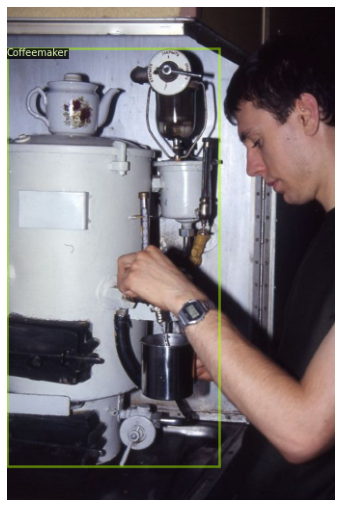

In [12]:
val_img_dicts = get_image_dicts(valid_path)

for d in random.sample(val_img_dicts, 1):
    print(d)
    img = cv2.imread(d["file_name"])
    
    img_shape = img.shape[:2]
    
    plt.figure(figsize=(img_shape[0]/75,img_shape[1]/75))
    visualizer = Visualizer(img[:, :, ::-1], metadata=coffee_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image())#[:, :, ::-1])
    plt.axis('off');

### Model configuration

In [13]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ('train/Coffeemaker',)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 500    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (coffeemaker)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[08/19 12:48:46 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Using train for annotations...
On dataset: train
Classes we're using: Coffeemaker    51
Name: ClassName, dtype: int64
[08/19 12:48:58 d2.data.build]: Removed 0 images with no usable annotations. 35 images left.
[08/19 12:48:58 d2.data.build]: Distribution of instances among all 1 categories:
|  category   | #instances   |
|:-----------:|:-------------|
| Coffeemaker | 51           |
|             |              |
[08/19 12:48:58 d2.data.common]: Serializing 35 elements to byte tensors and concatenating them all ...
[08/19 12:48:58 d2.data.common]: Serialized dataset takes 0.01 MiB
[08/19 12:48:58 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[08/19 12:48:58 d2.data.build]: Using training sampler TrainingSampler


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.


### Training

In [14]:
trainer.train()

[08/19 12:49:10 d2.engine.train_loop]: Starting training from iteration 0
[08/19 12:49:21 d2.utils.events]:  eta: 0:04:02  iter: 19  total_loss: 1.096  loss_cls: 0.660  loss_box_reg: 0.403  loss_rpn_cls: 0.029  loss_rpn_loc: 0.016  time: 0.5022  data_time: 0.0291  lr: 0.000050  max_mem: 2734M
[08/19 12:49:31 d2.utils.events]:  eta: 0:03:52  iter: 39  total_loss: 0.913  loss_cls: 0.416  loss_box_reg: 0.452  loss_rpn_cls: 0.026  loss_rpn_loc: 0.022  time: 0.4942  data_time: 0.0033  lr: 0.000100  max_mem: 2734M
[08/19 12:49:41 d2.utils.events]:  eta: 0:03:41  iter: 59  total_loss: 0.764  loss_cls: 0.302  loss_box_reg: 0.442  loss_rpn_cls: 0.016  loss_rpn_loc: 0.013  time: 0.4938  data_time: 0.0031  lr: 0.000150  max_mem: 2734M
[08/19 12:49:50 d2.utils.events]:  eta: 0:03:30  iter: 79  total_loss: 0.731  loss_cls: 0.247  loss_box_reg: 0.490  loss_rpn_cls: 0.022  loss_rpn_loc: 0.017  time: 0.4860  data_time: 0.0031  lr: 0.000200  max_mem: 2734M
[08/19 12:50:00 d2.utils.events]:  eta: 0:03:1

### Inference & evaluation using the trained model

Now, let's run inference with the trained model on the validation dataset. First, let's create a predictor using the model we just trained:

In [19]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set the testing threshold for this model
cfg.DATASETS.TEST = ("validation/Coffeemaker", )
predictor = DefaultPredictor(cfg)

{'instances': Instances(num_instances=1, image_height=683, image_width=1024, fields=[pred_boxes: Boxes(tensor([[106.3987,   0.0000, 998.7112, 680.1294]], device='cuda:0')), scores: tensor([0.9898], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}


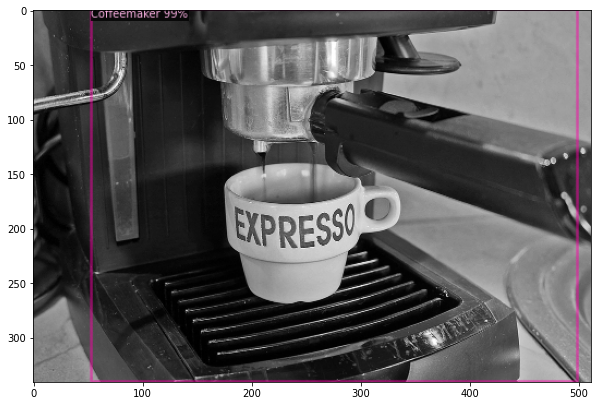

In [20]:
from detectron2.utils.visualizer import ColorMode


#val_img_dicts = get_image_dicts(valid_path)

plt.figure(figsize=(10,10))
for d in random.sample(val_img_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=coffee_metadata, 
                   scale=0.5 
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1])

### Evaluation

In [21]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


# We use COCOEvaluator which has simiar config style
evaluator = COCOEvaluator("validation/Coffeemaker", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "validation/Coffeemaker")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

[08/19 12:55:56 d2.evaluation.coco_evaluation]: 'validation/Coffeemaker' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
WARNING [08/19 12:55:56 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/validation/Coffeemaker_coco_format.json'. You need to clear the cache file if your dataset has been modified.
Using validation for annotations...
On dataset: validation
Classes we're using: Coffeemaker    18
Name: ClassName, dtype: int64
[08/19 12:55:57 d2.data.build]: Distribution of instances among all 1 categories:
|  category   | #instances   |
|:-----------:|:-------------|
| Coffeemaker | 18           |
|             |              |
[08/19 12:55:57 d2.data.common]: Serializing 17 elements to byte tensors and concatenating them all ...
[08/19 12:55:57 d2.data.common]: Serialized dataset takes 0.01 MiB
[08/19 12:55:57 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_l

OrderedDict([('bbox',
              {'AP': 60.151786157304976,
               'AP50': 88.2275756038602,
               'AP75': 76.15181927622044,
               'APs': nan,
               'APm': nan,
               'APl': 60.151786157304976})])

Wow!! AP(Avg Precision) of 60 is pretty amazing compared to what airnb has achieved (around 50) .offcourse we only considered single class here

## plain_train_net.py

I'm going to write out the plain_train_net.py script verbatim to see what it's doing.

https://github.com/facebookresearch/detectron2/blob/master/tools/plain_train_net.py

I'll leave notes and change it where I need to.

In [8]:
models = {
    "R50-FPN-1x": "COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml",
    "R50-FPN-3x": "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml",
    "R101-FPN-3x": "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml",
    "X101-FPN-3x": "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml",
    "RN-R50-1x": "COCO-Detection/retinanet_R_50_FPN_1x.yaml",
    "RN-R50-3x": "COCO-Detection/retinanet_R_50_FPN_3x.yaml",
    "RN-R101-3x": "COCO-Detection/retinanet_R_101_FPN_3x.yaml"
}

In [9]:
wandb.init(project="airbnb-object-detection", 
           sync_tensorboard=True)

W&B Run: https://app.wandb.ai/skumarr53/airbnb-object-detection/runs/2kewddba

In [39]:
coffee_metadata = register_datasets(train_path=train_path,
                                    valid_path=valid_path)

NameError: name 'train_path' is not defined

In [43]:
'train/cmaker-bathtub-treehouse-train' in DatasetCatalog._REGISTERED.keys()

True

### Train with Detectron's custom training script

The following code is original training code from the Detectron2 example notebook but I think we can make it better/suit our problem.

In [34]:
# Example use case of model_zoo
model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")

'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/model_final_b275ba.pkl'

In [35]:
model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")

'/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml'

In [59]:
config_path = '/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection'
train_path, valid_path = 'train/Coffeemaker', 'validation/Coffeemaker'

In [60]:
# Setup arg parser
parser = default_argument_parser() # default in Detectron2
args = parser.parse_args(f"--config-file {config_path}/faster_rcnn_R_50_FPN_1x.yaml \
                          MODEL.WEIGHTS https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/model_final_b275ba.pkl \
                          DATASETS.TRAIN ('{train_path}',) \
                          DATASETS.TEST ('{valid_path}',) \
                          DATALOADER.NUM_WORKERS 1 \
                          SOLVER.IMS_PER_BATCH 2 \
                          SOLVER.MAX_ITER 500 \
                          MODEL.ROI_HEADS.NUM_CLASSES 1".split())
# TODO: Add args to Weights & Biases
args

Namespace(config_file='/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml', dist_url='tcp://127.0.0.1:50152', eval_only=False, machine_rank=0, num_gpus=1, num_machines=1, opts=['MODEL.WEIGHTS', 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/model_final_b275ba.pkl', 'DATASETS.TRAIN', "('train/Coffeemaker',)", 'DATASETS.TEST', "('validation/Coffeemaker',)", 'DATALOADER.NUM_WORKERS', '1', 'SOLVER.IMS_PER_BATCH', '2', 'SOLVER.MAX_ITER', '500', 'MODEL.ROI_HEADS.NUM_CLASSES', '1'], resume=False)

In [62]:
main(args)

[08/19 22:21:13 detectron2]: Rank of current process: 0. World size: 1
[08/19 22:21:13 detectron2]: Rank of current process: 0. World size: 1
[08/19 22:21:13 detectron2]: Environment info:
----------------------  -------------------------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.3 | packaged by conda-forge | (default, Jun  1 2020, 17:43:00) [GCC 7.5.0]
numpy                   1.19.1
detectron2              0.2.1 @/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 10.0
detectron2 arch flags   /home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2/_C.cpython-38-x86_64-linux-gnu.so
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.4.0+cu100 @/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/torch
PyTorch debug build     False
GPU available           True
GPU 0

[08/19 22:21:13 detectron2]: Running with full config:
CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 1
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('validation/Coffeemaker',)
  TRAIN: ('train/Coffeemaker',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    F

[08/19 22:21:13 detectron2]: Full config saved to ./output/config.yaml
[08/19 22:21:13 detectron2]: Full config saved to ./output/config.yaml
[08/19 22:21:13 d2.utils.env]: Using a generated random seed 13921852
[08/19 22:21:13 d2.utils.env]: Using a generated random seed 13921852


Exception in thread Thread-135:
Traceback (most recent call last):
  File "/home/santhosh/miniconda3/envs/airnb/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/watchdog/observers/api.py", line 203, in run
    self.dispatch_events(self.event_queue, self.timeout)
  File "/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/watchdog/observers/api.py", line 376, in dispatch_events
    handler.dispatch(event)
  File "/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/watchdog/events.py", line 452, in dispatch
    super(PatternMatchingEventHandler, self).dispatch(event)
  File "/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/watchdog/events.py", line 331, in dispatch
    {
  File "/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/wandb/run_manager.py", line 697, in _on_file_modified
    self._get_file_event_handler(event.src_path, save_n

### Printing config_yaml file to go into Weights & Biases
{'CUDNN_BENCHMARK': False, 'DATALOADER': {'ASPECT_RATIO_GROUPING': True, 'FILTER_EMPTY_ANNOTATIONS': True, 'NUM_WORKERS': 1, 'REPEAT_THRESHOLD': 0.0, 'SAMPLER_TRAIN': 'TrainingSampler'}, 'DATASETS': {'PRECOMPUTED_PROPOSAL_TOPK_TEST': 1000, 'PRECOMPUTED_PROPOSAL_TOPK_TRAIN': 2000, 'PROPOSAL_FILES_TEST': [], 'PROPOSAL_FILES_TRAIN': [], 'TEST': ['validation/Coffeemaker'], 'TRAIN': ['train/Coffeemaker']}, 'GLOBAL': {'HACK': 1.0}, 'INPUT': {'CROP': {'ENABLED': False, 'SIZE': [0.9, 0.9], 'TYPE': 'relative_range'}, 'FORMAT': 'BGR', 'MASK_FORMAT': 'polygon', 'MAX_SIZE_TEST': 1333, 'MAX_SIZE_TRAIN': 1333, 'MIN_SIZE_TEST': 800, 'MIN_SIZE_TRAIN': [640, 672, 704, 736, 768, 800], 'MIN_SIZE_TRAIN_SAMPLING': 'choice'}, 'MODEL': {'ANCHOR_GENERATOR': {'ANGLES': [[-90, 0, 90]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'NAME': 'DefaultAnchorGenerator', 'OFFSET': 0.0, 'SIZES': [[32], [64], [128], [256], [512]]}, 'BACKBONE': {'FREEZE_AT': 2, 'NAME': 'bui

[08/19 22:21:17 detectron2]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequ

[08/19 22:21:17 fvcore.common.checkpoint]: Loading checkpoint from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/model_final_b275ba.pkl
[08/19 22:21:18 fvcore.common.checkpoint]: Reading a file from 'Detectron2 Model Zoo'
WARNING [08/19 22:21:18 fvcore.common.checkpoint]: Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
WARNING [08/19 22:21:18 fvcore.common.checkpoint]: Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
WARNING [08/19 22:21:18 fvcore.common.checkpoint]: Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the mo

[08/19 22:24:15 d2.utils.events]:  eta: 0:01:59  iter: 280  total_loss: 0.310  loss_cls: 0.135  loss_box_reg: 0.118  loss_rpn_cls: 0.021  loss_rpn_loc: 0.014  lr: 0.000020  max_mem: 3870M
[08/19 22:24:26 d2.utils.events]:  eta: 0:01:49  iter: 300  total_loss: 0.285  loss_cls: 0.134  loss_box_reg: 0.118  loss_rpn_cls: 0.020  loss_rpn_loc: 0.011  lr: 0.000020  max_mem: 3870M
[08/19 22:24:26 d2.utils.events]:  eta: 0:01:49  iter: 300  total_loss: 0.285  loss_cls: 0.134  loss_box_reg: 0.118  loss_rpn_cls: 0.020  loss_rpn_loc: 0.011  lr: 0.000020  max_mem: 3870M
[08/19 22:24:38 d2.utils.events]:  eta: 0:01:48  iter: 320  total_loss: 0.292  loss_cls: 0.139  loss_box_reg: 0.128  loss_rpn_cls: 0.012  loss_rpn_loc: 0.015  lr: 0.000020  max_mem: 3870M
[08/19 22:24:38 d2.utils.events]:  eta: 0:01:48  iter: 320  total_loss: 0.292  loss_cls: 0.139  loss_box_reg: 0.128  loss_rpn_cls: 0.012  loss_rpn_loc: 0.015  lr: 0.000020  max_mem: 3870M
[08/19 22:24:48 d2.utils.events]:  eta: 0:01:25  iter: 340  

[08/19 22:26:35 d2.evaluation.coco_evaluation]: Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |  APs  |  APm  |  APl   |
|:------:|:------:|:------:|:-----:|:-----:|:------:|
| 11.053 | 30.935 | 2.952  |  nan  |  nan  | 13.527 |
[08/19 22:26:35 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[08/19 22:26:35 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
### Returning results_i...
OrderedDict([('bbox', {'AP': 11.05339551469239, 'AP50': 30.93535494399573, 'AP75': 2.9524258093825573, 'APs': nan, 'APm': nan, 'APl': 13.527326828326483})])
[08/19 22:26:35 detectron2]: Evaluation results for validation/Coffeemaker in csv format:
[08/19 22:26:35 detectron2]: Evaluation results for validation/Coffeemaker in csv format:
### Calculating results...
[08/19 22:26:35 d2.evaluation.testing]: copypaste: Task: bbox
[08/19 22:26:35 d2.evaluation.testing]: copypaste: Task: bbox
[08/19 22:26:35 d2.evaluation.testing]: cop

OrderedDict([('bbox',
              {'AP': 11.05339551469239,
               'AP50': 30.93535494399573,
               'AP75': 2.9524258093825573,
               'APs': nan,
               'APm': nan,
               'APl': 13.527326828326483})])

In [ ]:
OrderedDict([('bbox',
              {'AP': 11.05339551469239,
               'AP50': 30.93535494399573,
               'AP75': 2.9524258093825573,
               'APs': nan,
               'APm': nan,
               'APl': 13.527326828326483})])

## Experimenting with Different models

### Training utilities

In [10]:
# Changed from original: Create evaluator for COCOEvaluator only
# Since we are only using bounding boxes to begin with, our evaluator can be simple COCO style
def get_evaluator(cfg, dataset_name, output_folder=None):
    """
    Create a COCOEvaluator
    """
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    evaluator = COCOEvaluator(dataset_name=dataset_name,
                              cfg=cfg,
                              distributed=False,
                              output_dir=output_folder)
    return evaluator


# Create testing function
def do_test(cfg, model):
    results = OrderedDict()
    for dataset_name in cfg.DATASETS.TEST:
        data_loader = build_detection_test_loader(cfg, dataset_name)
        # Create the evaluator
        evaluator = get_evaluator(cfg,
                                  dataset_name,
                                  output_folder=os.path.join(
                                      cfg.OUTPUT_DIR, "inference",
                                      dataset_name))
        # Make inference on dataset
        results_i = inference_on_dataset(model, data_loader, evaluator)
        # Update results dictionary
        results[dataset_name] = results_i

        print("### Returning results_i...")
        #print(results_i)
        #print(f"### Average Precision: {results_i['AP']}")
        # Let's get some communication happening
        if comm.is_main_process():
            logger.info("Evaluation results for {} in csv format:".format(
                dataset_name))
            ## wandb.log()? TODO/NOTE: This may be something Weights & Biases can track
            #print("### Calculating results...")
            print_csv_format(results_i)

        # Check to see length of results
        if len(results) == 1:
            results = list(results.values())[0]
        #print("### Returning results...")
        #print(results)

        # TODO : log results_i dict with different parameters
        print("### Saving results to Weights & Biases...")
        wandb.log(results_i)
        
        return results


# Create training function
def do_train(cfg, model, resume=False):
    # Set model to training mode
    model.train()
    # Create optimizer from config file (returns torch.nn.optimizer.Optimizer)
    optimizer = build_optimizer(cfg, model)
    # Create scheduler for learning rate (returns torch.optim.lr._LR_scheduler)
    scheduler = build_lr_scheduler(cfg, optimizer)
    print(f"Scheduler: {scheduler}")

    # Create checkpointer
    checkpointer = DetectionCheckpointer(model,
                                         save_dir=cfg.OUTPUT_DIR,
                                         optimizer=optimizer,
                                         scheduler=scheduler)

    # Create start iteration (refernces checkpointer) - https://detectron2.readthedocs.io/modules/checkpoint.html#detectron2.checkpoint.Checkpointer.resume_or_load
    start_iter = (
        # This can be 0
        checkpointer.resume_or_load(
            cfg.MODEL.
            WEIGHTS,  # Use predefined model weights (pretrained model)
            resume=resume).get("iteration", -1) + 1)
    # Set max number of iterations
    max_iter = cfg.SOLVER.MAX_ITER

    # Create periodiccheckpoint
    periodic_checkpointer = PeriodicCheckpointer(
        checkpointer=checkpointer,
        # How often to make checkpoints?
        period=cfg.SOLVER.CHECKPOINT_PERIOD,
        max_iter=max_iter)

    # Create writers (for saving checkpoints?)
    writers = ([
        # Print out common metrics such as iteration time, ETA, memory, all losses, learning rate
        CommonMetricPrinter(max_iter=max_iter),
        # Write scalars to a JSON file such as loss values, time and more
        JSONWriter(os.path.join(cfg.OUTPUT_DIR, "metrics.json")),
        # Write all scalars such as loss values to a TensorBoard file for easy visualization
        TensorboardXWriter(cfg.OUTPUT_DIR),
    ] if comm.is_main_process() else [])

    ### Original note from script: ###
    # compared to "train_net.py", we do not support accurate timing and precise BN
    # here, because they are not trivial to implement

    # Build a training data loader based off the training dataset name in the config
    data_loader = build_detection_train_loader(cfg)

    # Start logging
    logger.info("Starting training from iteration {}".format(start_iter))

    # Store events
    with EventStorage(start_iter) as storage:
        # Loop through zipped data loader and iteration
        for data, iteration in zip(data_loader, range(start_iter, max_iter)):
            iteration = iteration + 1
            storage.step(
            )  # update stroage with step - https://detectron2.readthedocs.io/modules/utils.html#detectron2.utils.events.EventStorage.step

            # Create loss dictionary by trying to model data
            loss_dict = model(data)
            losses = sum(loss_dict.values())
            # Are losses infinite? If so, something is wrong
            assert torch.isfinite(losses).all(), loss_dict

            # TODO - Not quite sure what's happening here
            loss_dict_reduced = {
                k: v.item()
                for k, v in comm.reduce_dict(loss_dict).items()
            }
            # Sum up losses
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())

            # # TODO: wandb.log()? log the losses
            # wandb.log({
            #         "Total loss": losses_reduced
            # })

            # Update storage
            if comm.is_main_process():
                # Store informate in storage - https://detectron2.readthedocs.io/modules/utils.html#detectron2.utils.events.EventStorage.put_scalars
                storage.put_scalars(total_loss=losses_reduced,
                                    **loss_dict_reduced)

            # Start doing PyTorch things
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            # Add learning rate to storage information
            storage.put_scalar("lr",
                               optimizer.param_groups[0]["lr"],
                               smoothing_hint=False)
            # This is required for your learning rate to change!!!! (not having this meant my learning rate was staying at 0)
            scheduler.step()

            # Perform evaluation?
            if (cfg.TEST.EVAL_PERIOD > 0
                    and iteration % cfg.TEST.EVAL_PERIOD == 0
                    and iteration != max_iter):
                do_test(cfg, model)
                # TODO - compared to "train_net.py", the test results are not dumped to EventStorage
                comm.synchronize()

            # Log different metrics with writers
            if iteration - start_iter > 5 and (iteration % 20 == 0
                                               or iteration == max_iter):
                for writer in writers:
                    writer.write()

            # Update the periodic_checkpointer
            periodic_checkpointer.step(iteration)


# Create setup function
def setup(args):
    """
    Create configs and perform basic setups.
    """
    cfg = get_cfg()
    cfg.merge_from_file(
        args.config_file)  # This will take some kind of model.yaml file
    cfg.merge_from_list(args.opts)
    cfg.freeze()
    default_setup(
        cfg, args
    )  # this logs the config and arguments passed to the command line to the output file

    # Load config YAML as dict
    cfg_yaml = cfg.load_yaml_with_base(
        os.path.join(cfg.OUTPUT_DIR, "config.yaml"))

    # default_config = get_cfg()
    # default_config_loaded = default_config.load_yaml_with_base("output/config.yaml")
    # default_config_loaded

    # TODO: turn config into YAML and save to weights & biases
    # TODO: Init wandb and add configs
    # Setup a new weights & biases run every time we run the setup() function
    wandb.init(project="airbnb-object-detection", sync_tensorboard=True)

    #print("### Printing config_yaml file to go into Weights & Biases")
    #print(cfg_yaml)
    wandb.config.update(cfg_yaml)

    return cfg

# Create main function
def main(args):
    
    # Create the config file
    cfg = setup(args)

    # Build the model
    model = build_model(cfg)
    
    # Log what's going on
    logger.info("Model:\n{}".format(model))

    # TODO: Fix this (if it doesn't work)
    #wandb.watch(model, log="all")

    # Only do evaluation if the args say so
    if args.eval_only:
        DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(
                cfg.MODEL.WEIGHTS, resume=args.resume
        )
        return do_test(cfg, model)

    # Do distributed training? (depends on number of GPUs available)
    distributed = comm.get_world_size() > 1
    if distributed:
        # Put the model on multiple devices if available
        model = DistributedDataParallel(
                model, 
                device_ids=[comm.get_local_rank()], 
                broadcast_buffers=False
        )

    # Train the model
    do_train(cfg, model)
    # TODO - May want to evaluate in a different step?
    return do_test(cfg, model)

### Selecting Model architecture

These are the models we try on subset data to come up with the best architecture in terms of performance and time trade-off.

In [30]:
## Generate JSON label file

_ = get_image_dicts('train/cmaker-bathtub-treehouse-train',
                     'train-annotations-bbox.csv',['Bathtub', 'Coffeemaker', 'Tree house'])

_ = get_image_dicts('validation/cmaker-bathtub-treehouse-validation',
                    'validation-annotations-bbox.csv',['Bathtub', 'Coffeemaker', 'Tree house'])



Using train-annotations-bbox.csv for annotations...
On dataset: train
Classes we're using:
 Bathtub        113
Tree house     110
Coffeemaker     51
Name: ClassName, dtype: int64
Total number of images: 252



Saving labels to: train/cmaker-bathtub-treehouse-train/train_labels.json...


In [11]:
models = {
    "R50-FPN-1x": "COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml",
    "R50-FPN-3x": "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml",
    "R101-FPN-3x": "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml",
    "X101-FPN-3x": "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml",
    "RN-R50-1x": "COCO-Detection/retinanet_R_50_FPN_1x.yaml",
    "RN-R50-3x": "COCO-Detection/retinanet_R_50_FPN_3x.yaml",
    "RN-R101-3x": "COCO-Detection/retinanet_R_101_FPN_3x.yaml"
}

For testing data subset from coffeemaker, bathtub, treehouse classes only are used.

In [12]:
# Setup arg parser
parser = default_argument_parser()

# register new datasets
cmaker_bathtub_metadata = register_datasets('train/cmaker-bathtub-treehouse-train',
                  'validation/cmaker-bathtub-treehouse-validation',
                  target_cls=["Bathtub", "Coffeemaker", "Tree house"])

Registering: cmaker-bathtub-treehouse-train
Registering: cmaker-bathtub-treehouse-validation


In [13]:
# Setup different weights and config files to try
weights = []
configs = []
for k, v in models.items():
    model = models[k]
    model_weights = model_zoo.get_checkpoint_url(model)
    weights.append(model_weights)
    config_file = model_zoo.get_config_file(model)
    configs.append(config_file)
    weights_configs = dict(zip(weights, configs))
weights_configs

{'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/model_final_b275ba.pkl': '/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml',
 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl': '/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml',
 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl': '/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml',
 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl': '/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2/model_zoo/configs/C

In [14]:
# Setup different arg strings to pass to main() 
workers = 2
ims_per_batch = 1                    # lower memory issues 
lr = 0.00025
max_iter = 3000
seed = 33                            # for reproducibility
num_classes = 3

arg_strings = []
for weights, config in weights_configs.items(): # try out diff models
    arg_string = f"--config-file {config} \
                MODEL.WEIGHTS {weights} \
                DATASETS.TRAIN ('train/cmaker-bathtub-treehouse-train',) \
                DATASETS.TEST ('validation/cmaker-bathtub-treehouse-validation',) \
                DATALOADER.NUM_WORKERS {workers} \
                SOLVER.IMS_PER_BATCH {ims_per_batch} \
                SOLVER.BASE_LR {lr} \
                SOLVER.MAX_ITER {max_iter} \
                SEED {seed} \
                MODEL.ROI_HEADS.NUM_CLASSES {num_classes}".split()
    arg_strings.append(arg_string)

In [52]:
len(arg_strings)

7

In [15]:
# Create different arg parsers
arg_list = []
for arg_string in arg_strings:
    args = parser.parse_args(arg_string)
    arg_list.append(args)

In [16]:
arg_list[0]

Namespace(config_file='/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml', dist_url='tcp://127.0.0.1:50152', eval_only=False, machine_rank=0, num_gpus=1, num_machines=1, opts=['MODEL.WEIGHTS', 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/model_final_b275ba.pkl', 'DATASETS.TRAIN', "('train/cmaker-bathtub-treehouse-train',)", 'DATASETS.TEST', "('validation/cmaker-bathtub-treehouse-validation',)", 'DATALOADER.NUM_WORKERS', '2', 'SOLVER.IMS_PER_BATCH', '1', 'SOLVER.BASE_LR', '0.00025', 'SOLVER.MAX_ITER', '3000', 'SEED', '33', 'MODEL.ROI_HEADS.NUM_CLASSES', '3'], resume=False)

In [17]:
if __name__ == "__main__":
    for i,arg in enumerate(arg_list):
        print(f">>>>>>>>>>>>> Running experiment: {i}")
        main(arg)

>>>>>>>>>>>>> Running experiment: 0
[08/23 19:52:02 detectron2]: Rank of current process: 0. World size: 1
[08/23 19:52:02 detectron2]: Rank of current process: 0. World size: 1
[08/23 19:52:02 detectron2]: Environment info:
----------------------  -------------------------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.3 | packaged by conda-forge | (default, Jun  1 2020, 17:43:00) [GCC 7.5.0]
numpy                   1.19.1
detectron2              0.2.1 @/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 10.0
detectron2 arch flags   /home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2/_C.cpython-38-x86_64-linux-gnu.so
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.4.0+cu100 @/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/torch
PyTorch debug build     Fals

[08/23 19:52:02 detectron2]: Running with full config:
CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('validation/cmaker-bathtub-treehouse-validation',)
  TRAIN: ('train/cmaker-bathtub-treehouse-train',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resn

[08/23 19:52:02 detectron2]: Full config saved to ./output/config.yaml
[08/23 19:52:02 detectron2]: Full config saved to ./output/config.yaml


[08/23 19:52:07 detectron2]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequ

[08/23 19:52:07 detectron2]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequ

Scheduler: <detectron2.solver.lr_scheduler.WarmupMultiStepLR object at 0x7fbd3802e070>
[08/23 19:52:07 fvcore.common.checkpoint]: Loading checkpoint from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/model_final_b275ba.pkl
[08/23 19:52:07 fvcore.common.file_io]: URL https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/model_final_b275ba.pkl cached in /home/santhosh/.torch/fvcore_cache/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/model_final_b275ba.pkl
[08/23 19:52:07 fvcore.common.checkpoint]: Reading a file from 'Detectron2 Model Zoo'
WARNING [08/23 19:52:07 fvcore.common.checkpoint]: Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
WARNING [08/23 19:52:07 fvcore.common.checkpoint]: Skip loading parameter 'roi_heads.box_pred

[08/23 19:53:09 d2.utils.events]:  eta: 0:12:19  iter: 220  total_loss: 0.235  loss_cls: 0.121  loss_box_reg: 0.078  loss_rpn_cls: 0.011  loss_rpn_loc: 0.012  lr: 0.000055  max_mem: 1619M
[08/23 19:53:09 d2.utils.events]:  eta: 0:12:19  iter: 220  total_loss: 0.235  loss_cls: 0.121  loss_box_reg: 0.078  loss_rpn_cls: 0.011  loss_rpn_loc: 0.012  lr: 0.000055  max_mem: 1619M
[08/23 19:53:14 d2.utils.events]:  eta: 0:12:20  iter: 240  total_loss: 0.285  loss_cls: 0.143  loss_box_reg: 0.116  loss_rpn_cls: 0.006  loss_rpn_loc: 0.007  lr: 0.000060  max_mem: 1619M
[08/23 19:53:14 d2.utils.events]:  eta: 0:12:20  iter: 240  total_loss: 0.285  loss_cls: 0.143  loss_box_reg: 0.116  loss_rpn_cls: 0.006  loss_rpn_loc: 0.007  lr: 0.000060  max_mem: 1619M
[08/23 19:53:20 d2.utils.events]:  eta: 0:13:59  iter: 260  total_loss: 0.304  loss_cls: 0.152  loss_box_reg: 0.132  loss_rpn_cls: 0.008  loss_rpn_loc: 0.009  lr: 0.000065  max_mem: 1619M
[08/23 19:53:20 d2.utils.events]:  eta: 0:13:59  iter: 260  

[08/23 19:55:03 d2.utils.events]:  eta: 0:10:21  iter: 640  total_loss: 0.201  loss_cls: 0.082  loss_box_reg: 0.100  loss_rpn_cls: 0.005  loss_rpn_loc: 0.009  lr: 0.000160  max_mem: 1619M
[08/23 19:55:03 d2.utils.events]:  eta: 0:10:21  iter: 640  total_loss: 0.201  loss_cls: 0.082  loss_box_reg: 0.100  loss_rpn_cls: 0.005  loss_rpn_loc: 0.009  lr: 0.000160  max_mem: 1619M
[08/23 19:55:08 d2.utils.events]:  eta: 0:10:33  iter: 660  total_loss: 0.287  loss_cls: 0.116  loss_box_reg: 0.148  loss_rpn_cls: 0.005  loss_rpn_loc: 0.006  lr: 0.000165  max_mem: 1619M
[08/23 19:55:08 d2.utils.events]:  eta: 0:10:33  iter: 660  total_loss: 0.287  loss_cls: 0.116  loss_box_reg: 0.148  loss_rpn_cls: 0.005  loss_rpn_loc: 0.006  lr: 0.000165  max_mem: 1619M
[08/23 19:55:14 d2.utils.events]:  eta: 0:11:31  iter: 680  total_loss: 0.208  loss_cls: 0.098  loss_box_reg: 0.091  loss_rpn_cls: 0.004  loss_rpn_loc: 0.008  lr: 0.000170  max_mem: 1619M
[08/23 19:55:14 d2.utils.events]:  eta: 0:11:31  iter: 680  

[08/23 19:57:02 d2.utils.events]:  eta: 0:10:33  iter: 1060  total_loss: 0.200  loss_cls: 0.059  loss_box_reg: 0.103  loss_rpn_cls: 0.002  loss_rpn_loc: 0.008  lr: 0.000250  max_mem: 1619M
[08/23 19:57:02 d2.utils.events]:  eta: 0:10:33  iter: 1060  total_loss: 0.200  loss_cls: 0.059  loss_box_reg: 0.103  loss_rpn_cls: 0.002  loss_rpn_loc: 0.008  lr: 0.000250  max_mem: 1619M
[08/23 19:57:07 d2.utils.events]:  eta: 0:08:58  iter: 1080  total_loss: 0.190  loss_cls: 0.064  loss_box_reg: 0.099  loss_rpn_cls: 0.002  loss_rpn_loc: 0.006  lr: 0.000250  max_mem: 1619M
[08/23 19:57:07 d2.utils.events]:  eta: 0:08:58  iter: 1080  total_loss: 0.190  loss_cls: 0.064  loss_box_reg: 0.099  loss_rpn_cls: 0.002  loss_rpn_loc: 0.006  lr: 0.000250  max_mem: 1619M
[08/23 19:57:13 d2.utils.events]:  eta: 0:08:34  iter: 1100  total_loss: 0.138  loss_cls: 0.044  loss_box_reg: 0.079  loss_rpn_cls: 0.005  loss_rpn_loc: 0.015  lr: 0.000250  max_mem: 1619M
[08/23 19:57:13 d2.utils.events]:  eta: 0:08:34  iter: 

[08/23 19:58:58 d2.utils.events]:  eta: 0:06:46  iter: 1480  total_loss: 0.112  loss_cls: 0.033  loss_box_reg: 0.052  loss_rpn_cls: 0.002  loss_rpn_loc: 0.018  lr: 0.000250  max_mem: 1619M
[08/23 19:58:58 d2.utils.events]:  eta: 0:06:46  iter: 1480  total_loss: 0.112  loss_cls: 0.033  loss_box_reg: 0.052  loss_rpn_cls: 0.002  loss_rpn_loc: 0.018  lr: 0.000250  max_mem: 1619M
[08/23 19:59:03 d2.utils.events]:  eta: 0:06:46  iter: 1500  total_loss: 0.150  loss_cls: 0.054  loss_box_reg: 0.075  loss_rpn_cls: 0.001  loss_rpn_loc: 0.007  lr: 0.000250  max_mem: 1619M
[08/23 19:59:03 d2.utils.events]:  eta: 0:06:46  iter: 1500  total_loss: 0.150  loss_cls: 0.054  loss_box_reg: 0.075  loss_rpn_cls: 0.001  loss_rpn_loc: 0.007  lr: 0.000250  max_mem: 1619M
[08/23 19:59:09 d2.utils.events]:  eta: 0:07:55  iter: 1520  total_loss: 0.154  loss_cls: 0.048  loss_box_reg: 0.062  loss_rpn_cls: 0.003  loss_rpn_loc: 0.006  lr: 0.000250  max_mem: 1619M
[08/23 19:59:09 d2.utils.events]:  eta: 0:07:55  iter: 

[08/23 20:00:58 d2.utils.events]:  eta: 0:06:04  iter: 1900  total_loss: 0.114  loss_cls: 0.040  loss_box_reg: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.006  lr: 0.000250  max_mem: 1619M
[08/23 20:00:58 d2.utils.events]:  eta: 0:06:04  iter: 1900  total_loss: 0.114  loss_cls: 0.040  loss_box_reg: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.006  lr: 0.000250  max_mem: 1619M
[08/23 20:01:03 d2.utils.events]:  eta: 0:04:48  iter: 1920  total_loss: 0.138  loss_cls: 0.036  loss_box_reg: 0.069  loss_rpn_cls: 0.002  loss_rpn_loc: 0.008  lr: 0.000250  max_mem: 1619M
[08/23 20:01:03 d2.utils.events]:  eta: 0:04:48  iter: 1920  total_loss: 0.138  loss_cls: 0.036  loss_box_reg: 0.069  loss_rpn_cls: 0.002  loss_rpn_loc: 0.008  lr: 0.000250  max_mem: 1619M
[08/23 20:01:08 d2.utils.events]:  eta: 0:04:39  iter: 1940  total_loss: 0.131  loss_cls: 0.049  loss_box_reg: 0.064  loss_rpn_cls: 0.002  loss_rpn_loc: 0.006  lr: 0.000250  max_mem: 1619M
[08/23 20:01:08 d2.utils.events]:  eta: 0:04:39  iter: 

[08/23 20:02:52 d2.utils.events]:  eta: 0:03:02  iter: 2320  total_loss: 0.094  loss_cls: 0.029  loss_box_reg: 0.048  loss_rpn_cls: 0.000  loss_rpn_loc: 0.007  lr: 0.000250  max_mem: 1619M
[08/23 20:02:52 d2.utils.events]:  eta: 0:03:02  iter: 2320  total_loss: 0.094  loss_cls: 0.029  loss_box_reg: 0.048  loss_rpn_cls: 0.000  loss_rpn_loc: 0.007  lr: 0.000250  max_mem: 1619M
[08/23 20:02:58 d2.utils.events]:  eta: 0:02:59  iter: 2340  total_loss: 0.117  loss_cls: 0.031  loss_box_reg: 0.061  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  lr: 0.000250  max_mem: 1619M
[08/23 20:02:58 d2.utils.events]:  eta: 0:02:59  iter: 2340  total_loss: 0.117  loss_cls: 0.031  loss_box_reg: 0.061  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  lr: 0.000250  max_mem: 1619M
[08/23 20:03:03 d2.utils.events]:  eta: 0:02:51  iter: 2360  total_loss: 0.117  loss_cls: 0.029  loss_box_reg: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.006  lr: 0.000250  max_mem: 1619M
[08/23 20:03:03 d2.utils.events]:  eta: 0:02:51  iter: 

[08/23 20:04:52 d2.utils.events]:  eta: 0:01:11  iter: 2740  total_loss: 0.125  loss_cls: 0.045  loss_box_reg: 0.056  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  lr: 0.000250  max_mem: 1619M
[08/23 20:04:52 d2.utils.events]:  eta: 0:01:11  iter: 2740  total_loss: 0.125  loss_cls: 0.045  loss_box_reg: 0.056  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  lr: 0.000250  max_mem: 1619M
[08/23 20:04:58 d2.utils.events]:  eta: 0:01:09  iter: 2760  total_loss: 0.108  loss_cls: 0.033  loss_box_reg: 0.042  loss_rpn_cls: 0.000  loss_rpn_loc: 0.007  lr: 0.000250  max_mem: 1619M
[08/23 20:04:58 d2.utils.events]:  eta: 0:01:09  iter: 2760  total_loss: 0.108  loss_cls: 0.033  loss_box_reg: 0.042  loss_rpn_cls: 0.000  loss_rpn_loc: 0.007  lr: 0.000250  max_mem: 1619M
[08/23 20:05:03 d2.utils.events]:  eta: 0:00:59  iter: 2780  total_loss: 0.104  loss_cls: 0.037  loss_box_reg: 0.052  loss_rpn_cls: 0.000  loss_rpn_loc: 0.009  lr: 0.000250  max_mem: 1619M
[08/23 20:05:03 d2.utils.events]:  eta: 0:00:59  iter: 

WARNING [08/23 20:06:16 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/inference/validation/cmaker-bathtub-treehouse-validation/validation/cmaker-bathtub-treehouse-validation_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[08/23 20:06:16 d2.evaluation.evaluator]: Start inference on 35 images
[08/23 20:06:16 d2.evaluation.evaluator]: Start inference on 35 images
[08/23 20:06:18 d2.evaluation.evaluator]: Inference done 11/35. 0.1176 s / img. ETA=0:00:02
[08/23 20:06:18 d2.evaluation.evaluator]: Inference done 11/35. 0.1176 s / img. ETA=0:00:02
[08/23 20:06:21 d2.evaluation.evaluator]: Total inference time: 0:00:03.732048 (0.124402 s / img per device, on 1 devices)
[08/23 20:06:21 d2.evaluation.evaluator]: Total inference time: 0:00:03.732048 (0.124402 s / img per device, on 1 devices)
[08/23 20:06:21 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:03 (0.121771 s / img per device, on 1 devices)

[08/23 20:06:21 detectron2]: Environment info:
----------------------  -------------------------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.3 | packaged by conda-forge | (default, Jun  1 2020, 17:43:00) [GCC 7.5.0]
numpy                   1.19.1
detectron2              0.2.1 @/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 10.0
detectron2 arch flags   /home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2/_C.cpython-38-x86_64-linux-gnu.so
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.4.0+cu100 @/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/torch
PyTorch debug build     False
GPU available           True
GPU 0                   GeForce GTX 1660
CUDA_HOME               None
Pillow                  7.2.0
torchvision             0.5.0+cu100 @/home/sant

[08/23 20:06:21 detectron2]: Running with full config:
CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('validation/cmaker-bathtub-treehouse-validation',)
  TRAIN: ('train/cmaker-bathtub-treehouse-train',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resn

[08/23 20:06:24 detectron2]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequ

[08/23 20:06:24 detectron2]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequ

Scheduler: <detectron2.solver.lr_scheduler.WarmupMultiStepLR object at 0x7fbd381509a0>
[08/23 20:06:24 fvcore.common.checkpoint]: Loading checkpoint from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl
[08/23 20:06:24 fvcore.common.file_io]: URL https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl cached in /home/santhosh/.torch/fvcore_cache/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl
[08/23 20:06:24 fvcore.common.checkpoint]: Reading a file from 'Detectron2 Model Zoo'
WARNING [08/23 20:06:24 fvcore.common.checkpoint]: Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
WARNING [08/23 20:06:24 fvcore.common.checkpoint]: Skip loading parameter 'roi_heads.box_pred

[08/23 20:07:33 d2.utils.events]:  eta: 0:11:48  iter: 260  total_loss: 0.312  loss_cls: 0.161  loss_box_reg: 0.133  loss_rpn_cls: 0.005  loss_rpn_loc: 0.010  lr: 0.000065  max_mem: 1620M
[08/23 20:07:38 d2.utils.events]:  eta: 0:11:08  iter: 280  total_loss: 0.217  loss_cls: 0.104  loss_box_reg: 0.105  loss_rpn_cls: 0.003  loss_rpn_loc: 0.007  lr: 0.000070  max_mem: 1620M
[08/23 20:07:38 d2.utils.events]:  eta: 0:11:08  iter: 280  total_loss: 0.217  loss_cls: 0.104  loss_box_reg: 0.105  loss_rpn_cls: 0.003  loss_rpn_loc: 0.007  lr: 0.000070  max_mem: 1620M
[08/23 20:07:43 d2.utils.events]:  eta: 0:11:30  iter: 300  total_loss: 0.250  loss_cls: 0.109  loss_box_reg: 0.081  loss_rpn_cls: 0.010  loss_rpn_loc: 0.007  lr: 0.000075  max_mem: 1620M
[08/23 20:07:43 d2.utils.events]:  eta: 0:11:30  iter: 300  total_loss: 0.250  loss_cls: 0.109  loss_box_reg: 0.081  loss_rpn_cls: 0.010  loss_rpn_loc: 0.007  lr: 0.000075  max_mem: 1620M
[08/23 20:07:48 d2.utils.events]:  eta: 0:12:16  iter: 320  

[08/23 20:09:31 d2.utils.events]:  eta: 0:12:26  iter: 680  total_loss: 0.207  loss_cls: 0.091  loss_box_reg: 0.101  loss_rpn_cls: 0.004  loss_rpn_loc: 0.007  lr: 0.000170  max_mem: 1620M
[08/23 20:09:37 d2.utils.events]:  eta: 0:11:34  iter: 700  total_loss: 0.198  loss_cls: 0.065  loss_box_reg: 0.092  loss_rpn_cls: 0.002  loss_rpn_loc: 0.011  lr: 0.000175  max_mem: 1620M
[08/23 20:09:37 d2.utils.events]:  eta: 0:11:34  iter: 700  total_loss: 0.198  loss_cls: 0.065  loss_box_reg: 0.092  loss_rpn_cls: 0.002  loss_rpn_loc: 0.011  lr: 0.000175  max_mem: 1620M
[08/23 20:09:43 d2.utils.events]:  eta: 0:10:59  iter: 720  total_loss: 0.227  loss_cls: 0.090  loss_box_reg: 0.108  loss_rpn_cls: 0.003  loss_rpn_loc: 0.007  lr: 0.000180  max_mem: 1620M
[08/23 20:09:43 d2.utils.events]:  eta: 0:10:59  iter: 720  total_loss: 0.227  loss_cls: 0.090  loss_box_reg: 0.108  loss_rpn_cls: 0.003  loss_rpn_loc: 0.007  lr: 0.000180  max_mem: 1620M
[08/23 20:09:48 d2.utils.events]:  eta: 0:11:05  iter: 740  

[08/23 20:11:30 d2.utils.events]:  eta: 0:08:36  iter: 1100  total_loss: 0.125  loss_cls: 0.033  loss_box_reg: 0.070  loss_rpn_cls: 0.001  loss_rpn_loc: 0.013  lr: 0.000250  max_mem: 1620M
[08/23 20:11:37 d2.utils.events]:  eta: 0:10:35  iter: 1120  total_loss: 0.162  loss_cls: 0.046  loss_box_reg: 0.100  loss_rpn_cls: 0.002  loss_rpn_loc: 0.005  lr: 0.000250  max_mem: 1620M
[08/23 20:11:37 d2.utils.events]:  eta: 0:10:35  iter: 1120  total_loss: 0.162  loss_cls: 0.046  loss_box_reg: 0.100  loss_rpn_cls: 0.002  loss_rpn_loc: 0.005  lr: 0.000250  max_mem: 1620M
[08/23 20:11:42 d2.utils.events]:  eta: 0:08:20  iter: 1140  total_loss: 0.182  loss_cls: 0.057  loss_box_reg: 0.102  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  lr: 0.000250  max_mem: 1620M
[08/23 20:11:42 d2.utils.events]:  eta: 0:08:20  iter: 1140  total_loss: 0.182  loss_cls: 0.057  loss_box_reg: 0.102  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  lr: 0.000250  max_mem: 1620M
[08/23 20:11:48 d2.utils.events]:  eta: 0:08:47  iter: 

[08/23 20:13:30 d2.utils.events]:  eta: 0:06:52  iter: 1520  total_loss: 0.133  loss_cls: 0.039  loss_box_reg: 0.052  loss_rpn_cls: 0.002  loss_rpn_loc: 0.006  lr: 0.000250  max_mem: 1620M
[08/23 20:13:35 d2.utils.events]:  eta: 0:06:38  iter: 1540  total_loss: 0.132  loss_cls: 0.043  loss_box_reg: 0.059  loss_rpn_cls: 0.000  loss_rpn_loc: 0.008  lr: 0.000250  max_mem: 1620M
[08/23 20:13:35 d2.utils.events]:  eta: 0:06:38  iter: 1540  total_loss: 0.132  loss_cls: 0.043  loss_box_reg: 0.059  loss_rpn_cls: 0.000  loss_rpn_loc: 0.008  lr: 0.000250  max_mem: 1620M
[08/23 20:13:41 d2.utils.events]:  eta: 0:06:25  iter: 1560  total_loss: 0.150  loss_cls: 0.037  loss_box_reg: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.013  lr: 0.000250  max_mem: 1620M
[08/23 20:13:41 d2.utils.events]:  eta: 0:06:25  iter: 1560  total_loss: 0.150  loss_cls: 0.037  loss_box_reg: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.013  lr: 0.000250  max_mem: 1620M
[08/23 20:13:47 d2.utils.events]:  eta: 0:06:56  iter: 

[08/23 20:15:27 d2.utils.events]:  eta: 0:04:44  iter: 1940  total_loss: 0.121  loss_cls: 0.037  loss_box_reg: 0.067  loss_rpn_cls: 0.001  loss_rpn_loc: 0.006  lr: 0.000250  max_mem: 1620M
[08/23 20:15:33 d2.utils.events]:  eta: 0:04:37  iter: 1960  total_loss: 0.103  loss_cls: 0.028  loss_box_reg: 0.044  loss_rpn_cls: 0.000  loss_rpn_loc: 0.006  lr: 0.000250  max_mem: 1620M
[08/23 20:15:33 d2.utils.events]:  eta: 0:04:37  iter: 1960  total_loss: 0.103  loss_cls: 0.028  loss_box_reg: 0.044  loss_rpn_cls: 0.000  loss_rpn_loc: 0.006  lr: 0.000250  max_mem: 1620M
[08/23 20:15:38 d2.utils.events]:  eta: 0:04:32  iter: 1980  total_loss: 0.128  loss_cls: 0.036  loss_box_reg: 0.051  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  lr: 0.000250  max_mem: 1620M
[08/23 20:15:38 d2.utils.events]:  eta: 0:04:32  iter: 1980  total_loss: 0.128  loss_cls: 0.036  loss_box_reg: 0.051  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  lr: 0.000250  max_mem: 1620M
[08/23 20:15:44 d2.utils.events]:  eta: 0:04:32  iter: 

[08/23 20:17:26 d2.utils.events]:  eta: 0:02:57  iter: 2360  total_loss: 0.100  loss_cls: 0.025  loss_box_reg: 0.047  loss_rpn_cls: 0.000  loss_rpn_loc: 0.007  lr: 0.000250  max_mem: 1620M
[08/23 20:17:32 d2.utils.events]:  eta: 0:03:14  iter: 2380  total_loss: 0.085  loss_cls: 0.024  loss_box_reg: 0.035  loss_rpn_cls: 0.000  loss_rpn_loc: 0.006  lr: 0.000250  max_mem: 1620M
[08/23 20:17:32 d2.utils.events]:  eta: 0:03:14  iter: 2380  total_loss: 0.085  loss_cls: 0.024  loss_box_reg: 0.035  loss_rpn_cls: 0.000  loss_rpn_loc: 0.006  lr: 0.000250  max_mem: 1620M
[08/23 20:17:37 d2.utils.events]:  eta: 0:02:41  iter: 2400  total_loss: 0.109  loss_cls: 0.036  loss_box_reg: 0.043  loss_rpn_cls: 0.000  loss_rpn_loc: 0.006  lr: 0.000250  max_mem: 1620M
[08/23 20:17:37 d2.utils.events]:  eta: 0:02:41  iter: 2400  total_loss: 0.109  loss_cls: 0.036  loss_box_reg: 0.043  loss_rpn_cls: 0.000  loss_rpn_loc: 0.006  lr: 0.000250  max_mem: 1620M
[08/23 20:17:43 d2.utils.events]:  eta: 0:02:33  iter: 

[08/23 20:19:29 d2.utils.events]:  eta: 0:00:58  iter: 2780  total_loss: 0.091  loss_cls: 0.031  loss_box_reg: 0.037  loss_rpn_cls: 0.000  loss_rpn_loc: 0.008  lr: 0.000250  max_mem: 1620M
[08/23 20:19:34 d2.utils.events]:  eta: 0:00:54  iter: 2800  total_loss: 0.076  loss_cls: 0.024  loss_box_reg: 0.034  loss_rpn_cls: 0.000  loss_rpn_loc: 0.007  lr: 0.000250  max_mem: 1620M
[08/23 20:19:34 d2.utils.events]:  eta: 0:00:54  iter: 2800  total_loss: 0.076  loss_cls: 0.024  loss_box_reg: 0.034  loss_rpn_cls: 0.000  loss_rpn_loc: 0.007  lr: 0.000250  max_mem: 1620M
[08/23 20:19:40 d2.utils.events]:  eta: 0:00:54  iter: 2820  total_loss: 0.075  loss_cls: 0.025  loss_box_reg: 0.033  loss_rpn_cls: 0.001  loss_rpn_loc: 0.008  lr: 0.000250  max_mem: 1620M
[08/23 20:19:40 d2.utils.events]:  eta: 0:00:54  iter: 2820  total_loss: 0.075  loss_cls: 0.025  loss_box_reg: 0.033  loss_rpn_cls: 0.001  loss_rpn_loc: 0.008  lr: 0.000250  max_mem: 1620M
[08/23 20:19:46 d2.utils.events]:  eta: 0:00:44  iter: 

[08/23 20:20:42 d2.evaluation.coco_evaluation]: Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |  APs  |  APm  |  APl   |
|:------:|:------:|:------:|:-----:|:-----:|:------:|
| 54.022 | 88.066 | 59.229 |  nan  |  nan  | 54.022 |
[08/23 20:20:42 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[08/23 20:20:42 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[08/23 20:20:42 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category    | AP     | category   | AP     |
|:-----------|:-------|:------------|:-------|:-----------|:-------|
| Bathtub    | 58.083 | Coffeemaker | 59.081 | Tree house | 44.901 |
[08/23 20:20:42 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category    | AP     | category   | AP     |
|:-----------|:-------|:------------|:-------|:-----------|:-------|
| Bathtub    | 58.083 | Coffeemaker | 59.081 | Tree house | 44.901 |
##

[08/23 20:20:42 detectron2]: Command line arguments: Namespace(config_file='/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml', dist_url='tcp://127.0.0.1:50152', eval_only=False, machine_rank=0, num_gpus=1, num_machines=1, opts=['MODEL.WEIGHTS', 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl', 'DATASETS.TRAIN', "('train/cmaker-bathtub-treehouse-train',)", 'DATASETS.TEST', "('validation/cmaker-bathtub-treehouse-validation',)", 'DATALOADER.NUM_WORKERS', '2', 'SOLVER.IMS_PER_BATCH', '1', 'SOLVER.BASE_LR', '0.00025', 'SOLVER.MAX_ITER', '3000', 'SEED', '33', 'MODEL.ROI_HEADS.NUM_CLASSES', '3'], resume=False)
[08/23 20:20:42 detectron2]: Contents of args.config_file=/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml:
_BASE_: "../Base-RCNN-FPN.yaml"
M

[08/23 20:20:42 detectron2]: Full config saved to ./output/config.yaml
[08/23 20:20:42 detectron2]: Full config saved to ./output/config.yaml


[08/23 20:20:45 detectron2]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequ

[08/23 20:20:45 detectron2]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequ

Scheduler: <detectron2.solver.lr_scheduler.WarmupMultiStepLR object at 0x7fbd3836c190>
[08/23 20:20:45 fvcore.common.checkpoint]: Loading checkpoint from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl
[08/23 20:20:45 fvcore.common.file_io]: URL https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl cached in /home/santhosh/.torch/fvcore_cache/detectron2/COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl
[08/23 20:20:47 fvcore.common.checkpoint]: Reading a file from 'Detectron2 Model Zoo'
WARNING [08/23 20:20:47 fvcore.common.checkpoint]: Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
WARNING [08/23 20:20:47 fvcore.common.checkpoint]: Skip loading parameter 'roi_heads.box_p

[08/23 20:22:27 d2.utils.events]:  eta: 0:19:35  iter: 260  total_loss: 0.318  loss_cls: 0.154  loss_box_reg: 0.118  loss_rpn_cls: 0.002  loss_rpn_loc: 0.009  lr: 0.000065  max_mem: 2265M
[08/23 20:22:34 d2.utils.events]:  eta: 0:16:00  iter: 280  total_loss: 0.236  loss_cls: 0.110  loss_box_reg: 0.113  loss_rpn_cls: 0.001  loss_rpn_loc: 0.006  lr: 0.000070  max_mem: 2265M
[08/23 20:22:34 d2.utils.events]:  eta: 0:16:00  iter: 280  total_loss: 0.236  loss_cls: 0.110  loss_box_reg: 0.113  loss_rpn_cls: 0.001  loss_rpn_loc: 0.006  lr: 0.000070  max_mem: 2265M
[08/23 20:22:41 d2.utils.events]:  eta: 0:16:00  iter: 300  total_loss: 0.241  loss_cls: 0.111  loss_box_reg: 0.076  loss_rpn_cls: 0.006  loss_rpn_loc: 0.007  lr: 0.000075  max_mem: 2265M
[08/23 20:22:41 d2.utils.events]:  eta: 0:16:00  iter: 300  total_loss: 0.241  loss_cls: 0.111  loss_box_reg: 0.076  loss_rpn_cls: 0.006  loss_rpn_loc: 0.007  lr: 0.000075  max_mem: 2265M
[08/23 20:22:49 d2.utils.events]:  eta: 0:17:28  iter: 320  

[08/23 20:25:07 d2.utils.events]:  eta: 0:15:04  iter: 680  total_loss: 0.208  loss_cls: 0.089  loss_box_reg: 0.099  loss_rpn_cls: 0.005  loss_rpn_loc: 0.007  lr: 0.000170  max_mem: 2265M
[08/23 20:25:15 d2.utils.events]:  eta: 0:14:43  iter: 700  total_loss: 0.181  loss_cls: 0.061  loss_box_reg: 0.085  loss_rpn_cls: 0.003  loss_rpn_loc: 0.009  lr: 0.000175  max_mem: 2265M
[08/23 20:25:15 d2.utils.events]:  eta: 0:14:43  iter: 700  total_loss: 0.181  loss_cls: 0.061  loss_box_reg: 0.085  loss_rpn_cls: 0.003  loss_rpn_loc: 0.009  lr: 0.000175  max_mem: 2265M
[08/23 20:25:23 d2.utils.events]:  eta: 0:15:10  iter: 720  total_loss: 0.220  loss_cls: 0.084  loss_box_reg: 0.107  loss_rpn_cls: 0.001  loss_rpn_loc: 0.006  lr: 0.000180  max_mem: 2265M
[08/23 20:25:23 d2.utils.events]:  eta: 0:15:10  iter: 720  total_loss: 0.220  loss_cls: 0.084  loss_box_reg: 0.107  loss_rpn_cls: 0.001  loss_rpn_loc: 0.006  lr: 0.000180  max_mem: 2265M
[08/23 20:25:31 d2.utils.events]:  eta: 0:15:08  iter: 740  

[08/23 20:27:50 d2.utils.events]:  eta: 0:12:11  iter: 1100  total_loss: 0.131  loss_cls: 0.036  loss_box_reg: 0.065  loss_rpn_cls: 0.002  loss_rpn_loc: 0.012  lr: 0.000250  max_mem: 2265M
[08/23 20:27:59 d2.utils.events]:  eta: 0:13:02  iter: 1120  total_loss: 0.155  loss_cls: 0.050  loss_box_reg: 0.086  loss_rpn_cls: 0.001  loss_rpn_loc: 0.005  lr: 0.000250  max_mem: 2265M
[08/23 20:27:59 d2.utils.events]:  eta: 0:13:02  iter: 1120  total_loss: 0.155  loss_cls: 0.050  loss_box_reg: 0.086  loss_rpn_cls: 0.001  loss_rpn_loc: 0.005  lr: 0.000250  max_mem: 2265M
[08/23 20:28:07 d2.utils.events]:  eta: 0:12:02  iter: 1140  total_loss: 0.162  loss_cls: 0.050  loss_box_reg: 0.094  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  lr: 0.000250  max_mem: 2265M
[08/23 20:28:07 d2.utils.events]:  eta: 0:12:02  iter: 1140  total_loss: 0.162  loss_cls: 0.050  loss_box_reg: 0.094  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  lr: 0.000250  max_mem: 2265M
[08/23 20:28:15 d2.utils.events]:  eta: 0:12:15  iter: 

[08/23 20:30:34 d2.utils.events]:  eta: 0:09:28  iter: 1520  total_loss: 0.112  loss_cls: 0.036  loss_box_reg: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.003  lr: 0.000250  max_mem: 2265M
[08/23 20:30:43 d2.utils.events]:  eta: 0:10:49  iter: 1540  total_loss: 0.107  loss_cls: 0.035  loss_box_reg: 0.061  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  lr: 0.000250  max_mem: 2265M
[08/23 20:30:43 d2.utils.events]:  eta: 0:10:49  iter: 1540  total_loss: 0.107  loss_cls: 0.035  loss_box_reg: 0.061  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  lr: 0.000250  max_mem: 2265M
[08/23 20:30:51 d2.utils.events]:  eta: 0:09:23  iter: 1560  total_loss: 0.128  loss_cls: 0.035  loss_box_reg: 0.060  loss_rpn_cls: 0.001  loss_rpn_loc: 0.012  lr: 0.000250  max_mem: 2265M
[08/23 20:30:51 d2.utils.events]:  eta: 0:09:23  iter: 1560  total_loss: 0.128  loss_cls: 0.035  loss_box_reg: 0.060  loss_rpn_cls: 0.001  loss_rpn_loc: 0.012  lr: 0.000250  max_mem: 2265M
[08/23 20:30:59 d2.utils.events]:  eta: 0:09:46  iter: 

[08/23 20:33:18 d2.utils.events]:  eta: 0:06:33  iter: 1940  total_loss: 0.093  loss_cls: 0.036  loss_box_reg: 0.052  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  lr: 0.000250  max_mem: 2265M
[08/23 20:33:25 d2.utils.events]:  eta: 0:06:22  iter: 1960  total_loss: 0.098  loss_cls: 0.024  loss_box_reg: 0.038  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  lr: 0.000250  max_mem: 2265M
[08/23 20:33:25 d2.utils.events]:  eta: 0:06:22  iter: 1960  total_loss: 0.098  loss_cls: 0.024  loss_box_reg: 0.038  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  lr: 0.000250  max_mem: 2265M
[08/23 20:33:33 d2.utils.events]:  eta: 0:06:23  iter: 1980  total_loss: 0.111  loss_cls: 0.039  loss_box_reg: 0.055  loss_rpn_cls: 0.000  loss_rpn_loc: 0.009  lr: 0.000250  max_mem: 2265M
[08/23 20:33:33 d2.utils.events]:  eta: 0:06:23  iter: 1980  total_loss: 0.111  loss_cls: 0.039  loss_box_reg: 0.055  loss_rpn_cls: 0.000  loss_rpn_loc: 0.009  lr: 0.000250  max_mem: 2265M
[08/23 20:33:40 d2.utils.events]:  eta: 0:06:15  iter: 

[08/23 20:35:59 d2.utils.events]:  eta: 0:03:58  iter: 2360  total_loss: 0.086  loss_cls: 0.025  loss_box_reg: 0.044  loss_rpn_cls: 0.000  loss_rpn_loc: 0.006  lr: 0.000250  max_mem: 2265M
[08/23 20:36:07 d2.utils.events]:  eta: 0:04:03  iter: 2380  total_loss: 0.063  loss_cls: 0.019  loss_box_reg: 0.025  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  lr: 0.000250  max_mem: 2265M
[08/23 20:36:07 d2.utils.events]:  eta: 0:04:03  iter: 2380  total_loss: 0.063  loss_cls: 0.019  loss_box_reg: 0.025  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  lr: 0.000250  max_mem: 2265M
[08/23 20:36:14 d2.utils.events]:  eta: 0:03:41  iter: 2400  total_loss: 0.081  loss_cls: 0.023  loss_box_reg: 0.030  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  lr: 0.000250  max_mem: 2265M
[08/23 20:36:14 d2.utils.events]:  eta: 0:03:41  iter: 2400  total_loss: 0.081  loss_cls: 0.023  loss_box_reg: 0.030  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  lr: 0.000250  max_mem: 2265M
[08/23 20:36:22 d2.utils.events]:  eta: 0:03:27  iter: 

[08/23 20:38:40 d2.utils.events]:  eta: 0:01:18  iter: 2780  total_loss: 0.087  loss_cls: 0.022  loss_box_reg: 0.045  loss_rpn_cls: 0.000  loss_rpn_loc: 0.006  lr: 0.000250  max_mem: 2265M
[08/23 20:38:47 d2.utils.events]:  eta: 0:01:15  iter: 2800  total_loss: 0.063  loss_cls: 0.018  loss_box_reg: 0.029  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  lr: 0.000250  max_mem: 2265M
[08/23 20:38:47 d2.utils.events]:  eta: 0:01:15  iter: 2800  total_loss: 0.063  loss_cls: 0.018  loss_box_reg: 0.029  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  lr: 0.000250  max_mem: 2265M
[08/23 20:38:56 d2.utils.events]:  eta: 0:01:13  iter: 2820  total_loss: 0.070  loss_cls: 0.021  loss_box_reg: 0.031  loss_rpn_cls: 0.000  loss_rpn_loc: 0.009  lr: 0.000250  max_mem: 2265M
[08/23 20:38:56 d2.utils.events]:  eta: 0:01:13  iter: 2820  total_loss: 0.070  loss_cls: 0.021  loss_box_reg: 0.031  loss_rpn_cls: 0.000  loss_rpn_loc: 0.009  lr: 0.000250  max_mem: 2265M
[08/23 20:39:03 d2.utils.events]:  eta: 0:01:01  iter: 

[08/23 20:40:20 d2.evaluation.coco_evaluation]: Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |  APs  |  APm  |  APl   |
|:------:|:------:|:------:|:-----:|:-----:|:------:|
| 62.160 | 94.574 | 69.322 |  nan  |  nan  | 62.160 |
[08/23 20:40:20 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[08/23 20:40:20 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[08/23 20:40:20 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category    | AP     | category   | AP     |
|:-----------|:-------|:------------|:-------|:-----------|:-------|
| Bathtub    | 63.646 | Coffeemaker | 70.720 | Tree house | 52.112 |
[08/23 20:40:20 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category    | AP     | category   | AP     |
|:-----------|:-------|:------------|:-------|:-----------|:-------|
| Bathtub    | 63.646 | Coffeemaker | 70.720 | Tree house | 52.112 |
##

[08/23 20:40:21 detectron2]: Command line arguments: Namespace(config_file='/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml', dist_url='tcp://127.0.0.1:50152', eval_only=False, machine_rank=0, num_gpus=1, num_machines=1, opts=['MODEL.WEIGHTS', 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl', 'DATASETS.TRAIN', "('train/cmaker-bathtub-treehouse-train',)", 'DATASETS.TEST', "('validation/cmaker-bathtub-treehouse-validation',)", 'DATALOADER.NUM_WORKERS', '2', 'SOLVER.IMS_PER_BATCH', '1', 'SOLVER.BASE_LR', '0.00025', 'SOLVER.MAX_ITER', '3000', 'SEED', '33', 'MODEL.ROI_HEADS.NUM_CLASSES', '3'], resume=False)
[08/23 20:40:21 detectron2]: Contents of args.config_file=/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml:
_BASE_: "../Bas

[08/23 20:40:21 detectron2]: Full config saved to ./output/config.yaml
[08/23 20:40:21 detectron2]: Full config saved to ./output/config.yaml


[08/23 20:40:25 detectron2]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequ

[08/23 20:40:25 detectron2]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequ

Scheduler: <detectron2.solver.lr_scheduler.WarmupMultiStepLR object at 0x7fbd3803a670>
[08/23 20:40:25 fvcore.common.checkpoint]: Loading checkpoint from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl
[08/23 20:40:25 fvcore.common.file_io]: URL https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl cached in /home/santhosh/.torch/fvcore_cache/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl
[08/23 20:40:28 fvcore.common.checkpoint]: Reading a file from 'Detectron2 Model Zoo'
WARNING [08/23 20:40:28 fvcore.common.checkpoint]: Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
WARNING [08/23 20:40:28 fvcore.common.checkpoint]: Skip loading paramete

[08/23 20:43:33 d2.utils.events]:  eta: 0:31:31  iter: 260  total_loss: 0.285  loss_cls: 0.151  loss_box_reg: 0.120  loss_rpn_cls: 0.004  loss_rpn_loc: 0.008  lr: 0.000065  max_mem: 3743M
[08/23 20:43:46 d2.utils.events]:  eta: 0:29:40  iter: 280  total_loss: 0.225  loss_cls: 0.111  loss_box_reg: 0.106  loss_rpn_cls: 0.001  loss_rpn_loc: 0.006  lr: 0.000070  max_mem: 3743M
[08/23 20:43:46 d2.utils.events]:  eta: 0:29:40  iter: 280  total_loss: 0.225  loss_cls: 0.111  loss_box_reg: 0.106  loss_rpn_cls: 0.001  loss_rpn_loc: 0.006  lr: 0.000070  max_mem: 3743M
[08/23 20:44:00 d2.utils.events]:  eta: 0:31:01  iter: 300  total_loss: 0.271  loss_cls: 0.125  loss_box_reg: 0.101  loss_rpn_cls: 0.008  loss_rpn_loc: 0.007  lr: 0.000075  max_mem: 3743M
[08/23 20:44:00 d2.utils.events]:  eta: 0:31:01  iter: 300  total_loss: 0.271  loss_cls: 0.125  loss_box_reg: 0.101  loss_rpn_cls: 0.008  loss_rpn_loc: 0.007  lr: 0.000075  max_mem: 3743M
[08/23 20:44:14 d2.utils.events]:  eta: 0:33:18  iter: 320  

[08/23 20:48:35 d2.utils.events]:  eta: 0:29:02  iter: 680  total_loss: 0.217  loss_cls: 0.094  loss_box_reg: 0.104  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  lr: 0.000170  max_mem: 3743M
[08/23 20:48:50 d2.utils.events]:  eta: 0:27:38  iter: 700  total_loss: 0.179  loss_cls: 0.061  loss_box_reg: 0.083  loss_rpn_cls: 0.001  loss_rpn_loc: 0.008  lr: 0.000175  max_mem: 3743M
[08/23 20:48:50 d2.utils.events]:  eta: 0:27:38  iter: 700  total_loss: 0.179  loss_cls: 0.061  loss_box_reg: 0.083  loss_rpn_cls: 0.001  loss_rpn_loc: 0.008  lr: 0.000175  max_mem: 3743M
[08/23 20:49:05 d2.utils.events]:  eta: 0:29:02  iter: 720  total_loss: 0.208  loss_cls: 0.080  loss_box_reg: 0.089  loss_rpn_cls: 0.002  loss_rpn_loc: 0.005  lr: 0.000180  max_mem: 3743M
[08/23 20:49:05 d2.utils.events]:  eta: 0:29:02  iter: 720  total_loss: 0.208  loss_cls: 0.080  loss_box_reg: 0.089  loss_rpn_cls: 0.002  loss_rpn_loc: 0.005  lr: 0.000180  max_mem: 3743M
[08/23 20:49:21 d2.utils.events]:  eta: 0:29:27  iter: 740  

[08/23 20:53:42 d2.utils.events]:  eta: 0:23:19  iter: 1100  total_loss: 0.129  loss_cls: 0.029  loss_box_reg: 0.072  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  lr: 0.000250  max_mem: 3743M
[08/23 20:53:56 d2.utils.events]:  eta: 0:23:02  iter: 1120  total_loss: 0.149  loss_cls: 0.042  loss_box_reg: 0.090  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  lr: 0.000250  max_mem: 3743M
[08/23 20:53:56 d2.utils.events]:  eta: 0:23:02  iter: 1120  total_loss: 0.149  loss_cls: 0.042  loss_box_reg: 0.090  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  lr: 0.000250  max_mem: 3743M
[08/23 20:54:10 d2.utils.events]:  eta: 0:21:37  iter: 1140  total_loss: 0.151  loss_cls: 0.046  loss_box_reg: 0.086  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  lr: 0.000250  max_mem: 3743M
[08/23 20:54:10 d2.utils.events]:  eta: 0:21:37  iter: 1140  total_loss: 0.151  loss_cls: 0.046  loss_box_reg: 0.086  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  lr: 0.000250  max_mem: 3743M
[08/23 20:54:25 d2.utils.events]:  eta: 0:23:05  iter: 

[08/23 20:58:47 d2.utils.events]:  eta: 0:18:43  iter: 1520  total_loss: 0.108  loss_cls: 0.029  loss_box_reg: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.005  lr: 0.000250  max_mem: 3743M
[08/23 20:59:01 d2.utils.events]:  eta: 0:17:06  iter: 1540  total_loss: 0.111  loss_cls: 0.032  loss_box_reg: 0.058  loss_rpn_cls: 0.000  loss_rpn_loc: 0.006  lr: 0.000250  max_mem: 3743M
[08/23 20:59:01 d2.utils.events]:  eta: 0:17:06  iter: 1540  total_loss: 0.111  loss_cls: 0.032  loss_box_reg: 0.058  loss_rpn_cls: 0.000  loss_rpn_loc: 0.006  lr: 0.000250  max_mem: 3743M
[08/23 20:59:15 d2.utils.events]:  eta: 0:16:49  iter: 1560  total_loss: 0.129  loss_cls: 0.028  loss_box_reg: 0.060  loss_rpn_cls: 0.000  loss_rpn_loc: 0.012  lr: 0.000250  max_mem: 3743M
[08/23 20:59:15 d2.utils.events]:  eta: 0:16:49  iter: 1560  total_loss: 0.129  loss_cls: 0.028  loss_box_reg: 0.060  loss_rpn_cls: 0.000  loss_rpn_loc: 0.012  lr: 0.000250  max_mem: 3743M
[08/23 20:59:30 d2.utils.events]:  eta: 0:18:05  iter: 

[08/23 21:03:51 d2.utils.events]:  eta: 0:12:22  iter: 1940  total_loss: 0.082  loss_cls: 0.025  loss_box_reg: 0.049  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  lr: 0.000250  max_mem: 3743M
[08/23 21:04:05 d2.utils.events]:  eta: 0:12:12  iter: 1960  total_loss: 0.076  loss_cls: 0.019  loss_box_reg: 0.036  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  lr: 0.000250  max_mem: 3743M
[08/23 21:04:05 d2.utils.events]:  eta: 0:12:12  iter: 1960  total_loss: 0.076  loss_cls: 0.019  loss_box_reg: 0.036  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  lr: 0.000250  max_mem: 3743M
[08/23 21:04:19 d2.utils.events]:  eta: 0:11:40  iter: 1980  total_loss: 0.094  loss_cls: 0.022  loss_box_reg: 0.044  loss_rpn_cls: 0.000  loss_rpn_loc: 0.008  lr: 0.000250  max_mem: 3743M
[08/23 21:04:19 d2.utils.events]:  eta: 0:11:40  iter: 1980  total_loss: 0.094  loss_cls: 0.022  loss_box_reg: 0.044  loss_rpn_cls: 0.000  loss_rpn_loc: 0.008  lr: 0.000250  max_mem: 3743M
[08/23 21:04:33 d2.utils.events]:  eta: 0:12:01  iter: 

[08/23 21:08:56 d2.utils.events]:  eta: 0:07:36  iter: 2360  total_loss: 0.087  loss_cls: 0.022  loss_box_reg: 0.043  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  lr: 0.000250  max_mem: 3743M
[08/23 21:09:10 d2.utils.events]:  eta: 0:07:29  iter: 2380  total_loss: 0.064  loss_cls: 0.016  loss_box_reg: 0.032  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  lr: 0.000250  max_mem: 3743M
[08/23 21:09:10 d2.utils.events]:  eta: 0:07:29  iter: 2380  total_loss: 0.064  loss_cls: 0.016  loss_box_reg: 0.032  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  lr: 0.000250  max_mem: 3743M
[08/23 21:09:24 d2.utils.events]:  eta: 0:07:06  iter: 2400  total_loss: 0.079  loss_cls: 0.026  loss_box_reg: 0.044  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  lr: 0.000250  max_mem: 3743M
[08/23 21:09:24 d2.utils.events]:  eta: 0:07:06  iter: 2400  total_loss: 0.079  loss_cls: 0.026  loss_box_reg: 0.044  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  lr: 0.000250  max_mem: 3743M
[08/23 21:09:38 d2.utils.events]:  eta: 0:06:42  iter: 

[08/23 21:14:02 d2.utils.events]:  eta: 0:02:26  iter: 2780  total_loss: 0.065  loss_cls: 0.020  loss_box_reg: 0.034  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  lr: 0.000250  max_mem: 3743M
[08/23 21:14:16 d2.utils.events]:  eta: 0:02:22  iter: 2800  total_loss: 0.058  loss_cls: 0.016  loss_box_reg: 0.027  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  lr: 0.000250  max_mem: 3743M
[08/23 21:14:16 d2.utils.events]:  eta: 0:02:22  iter: 2800  total_loss: 0.058  loss_cls: 0.016  loss_box_reg: 0.027  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  lr: 0.000250  max_mem: 3743M
[08/23 21:14:32 d2.utils.events]:  eta: 0:02:25  iter: 2820  total_loss: 0.054  loss_cls: 0.016  loss_box_reg: 0.026  loss_rpn_cls: 0.000  loss_rpn_loc: 0.006  lr: 0.000250  max_mem: 3743M
[08/23 21:14:32 d2.utils.events]:  eta: 0:02:25  iter: 2820  total_loss: 0.054  loss_cls: 0.016  loss_box_reg: 0.026  loss_rpn_cls: 0.000  loss_rpn_loc: 0.006  lr: 0.000250  max_mem: 3743M
[08/23 21:14:47 d2.utils.events]:  eta: 0:01:59  iter: 

[08/23 21:17:12 d2.evaluation.coco_evaluation]: Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |  APs  |  APm  |  APl   |
|:------:|:------:|:------:|:-----:|:-----:|:------:|
| 56.058 | 90.646 | 60.362 |  nan  |  nan  | 56.075 |
[08/23 21:17:12 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[08/23 21:17:12 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[08/23 21:17:12 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category    | AP     | category   | AP     |
|:-----------|:-------|:------------|:-------|:-----------|:-------|
| Bathtub    | 63.888 | Coffeemaker | 52.255 | Tree house | 52.030 |
[08/23 21:17:12 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP     | category    | AP     | category   | AP     |
|:-----------|:-------|:------------|:-------|:-----------|:-------|
| Bathtub    | 63.888 | Coffeemaker | 52.255 | Tree house | 52.030 |
##

[08/23 21:17:12 detectron2]: Command line arguments: Namespace(config_file='/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/retinanet_R_50_FPN_1x.yaml', dist_url='tcp://127.0.0.1:50152', eval_only=False, machine_rank=0, num_gpus=1, num_machines=1, opts=['MODEL.WEIGHTS', 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_50_FPN_1x/190397773/model_final_bfca0b.pkl', 'DATASETS.TRAIN', "('train/cmaker-bathtub-treehouse-train',)", 'DATASETS.TEST', "('validation/cmaker-bathtub-treehouse-validation',)", 'DATALOADER.NUM_WORKERS', '2', 'SOLVER.IMS_PER_BATCH', '1', 'SOLVER.BASE_LR', '0.00025', 'SOLVER.MAX_ITER', '3000', 'SEED', '33', 'MODEL.ROI_HEADS.NUM_CLASSES', '3'], resume=False)
[08/23 21:17:12 detectron2]: Command line arguments: Namespace(config_file='/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/retinanet_R_50_FPN_1x.yaml', dist_url='tcp://127.0.0

[08/23 21:17:12 detectron2]: Full config saved to ./output/config.yaml
[08/23 21:17:12 detectron2]: Full config saved to ./output/config.yaml


[08/23 21:17:15 detectron2]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequen

[08/23 21:17:15 detectron2]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequen

Scheduler: <detectron2.solver.lr_scheduler.WarmupMultiStepLR object at 0x7fbd2048edf0>
[08/23 21:17:15 fvcore.common.checkpoint]: Loading checkpoint from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_50_FPN_1x/190397773/model_final_bfca0b.pkl
[08/23 21:17:15 fvcore.common.file_io]: URL https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_50_FPN_1x/190397773/model_final_bfca0b.pkl cached in /home/santhosh/.torch/fvcore_cache/detectron2/COCO-Detection/retinanet_R_50_FPN_1x/190397773/model_final_bfca0b.pkl
[08/23 21:17:16 fvcore.common.checkpoint]: Reading a file from 'Detectron2 Model Zoo'
[08/23 21:17:16 d2.data.build]: Removed 0 images with no usable annotations. 252 images left.
[08/23 21:17:16 d2.data.build]: Removed 0 images with no usable annotations. 252 images left.
[08/23 21:17:16 d2.data.common]: Serializing 252 elements to byte tensors and concatenating them all ...
[08/23 21:17:16 d2.data.common]: Serializing 252 elements to byte tensors

[08/23 21:19:17 d2.utils.events]:  eta: 0:12:16  iter: 420  total_loss: 0.256  loss_cls: 0.094  loss_box_reg: 0.160  lr: 0.000105  max_mem: 3743M
[08/23 21:19:23 d2.utils.events]:  eta: 0:12:48  iter: 440  total_loss: 0.454  loss_cls: 0.209  loss_box_reg: 0.217  lr: 0.000110  max_mem: 3743M
[08/23 21:19:23 d2.utils.events]:  eta: 0:12:48  iter: 440  total_loss: 0.454  loss_cls: 0.209  loss_box_reg: 0.217  lr: 0.000110  max_mem: 3743M
[08/23 21:19:30 d2.utils.events]:  eta: 0:13:44  iter: 460  total_loss: 0.403  loss_cls: 0.160  loss_box_reg: 0.249  lr: 0.000115  max_mem: 3743M
[08/23 21:19:30 d2.utils.events]:  eta: 0:13:44  iter: 460  total_loss: 0.403  loss_cls: 0.160  loss_box_reg: 0.249  lr: 0.000115  max_mem: 3743M
[08/23 21:19:36 d2.utils.events]:  eta: 0:11:49  iter: 480  total_loss: 0.349  loss_cls: 0.175  loss_box_reg: 0.169  lr: 0.000120  max_mem: 3743M
[08/23 21:19:36 d2.utils.events]:  eta: 0:11:49  iter: 480  total_loss: 0.349  loss_cls: 0.175  loss_box_reg: 0.169  lr: 0.0

[08/23 21:21:59 d2.utils.events]:  eta: 0:09:18  iter: 960  total_loss: 0.259  loss_cls: 0.128  loss_box_reg: 0.116  lr: 0.000240  max_mem: 3743M
[08/23 21:21:59 d2.utils.events]:  eta: 0:09:18  iter: 960  total_loss: 0.259  loss_cls: 0.128  loss_box_reg: 0.116  lr: 0.000240  max_mem: 3743M
[08/23 21:22:05 d2.utils.events]:  eta: 0:09:56  iter: 980  total_loss: 0.224  loss_cls: 0.109  loss_box_reg: 0.103  lr: 0.000245  max_mem: 3743M
[08/23 21:22:05 d2.utils.events]:  eta: 0:09:56  iter: 980  total_loss: 0.224  loss_cls: 0.109  loss_box_reg: 0.103  lr: 0.000245  max_mem: 3743M
[08/23 21:22:10 d2.utils.events]:  eta: 0:09:36  iter: 1000  total_loss: 0.379  loss_cls: 0.118  loss_box_reg: 0.256  lr: 0.000250  max_mem: 3743M
[08/23 21:22:10 d2.utils.events]:  eta: 0:09:36  iter: 1000  total_loss: 0.379  loss_cls: 0.118  loss_box_reg: 0.256  lr: 0.000250  max_mem: 3743M
[08/23 21:22:16 d2.utils.events]:  eta: 0:09:58  iter: 1020  total_loss: 0.253  loss_cls: 0.098  loss_box_reg: 0.131  lr: 

[08/23 21:24:31 d2.utils.events]:  eta: 0:07:19  iter: 1480  total_loss: 0.162  loss_cls: 0.069  loss_box_reg: 0.112  lr: 0.000250  max_mem: 3743M
[08/23 21:24:37 d2.utils.events]:  eta: 0:07:19  iter: 1500  total_loss: 0.197  loss_cls: 0.070  loss_box_reg: 0.117  lr: 0.000250  max_mem: 3743M
[08/23 21:24:37 d2.utils.events]:  eta: 0:07:19  iter: 1500  total_loss: 0.197  loss_cls: 0.070  loss_box_reg: 0.117  lr: 0.000250  max_mem: 3743M
[08/23 21:24:43 d2.utils.events]:  eta: 0:07:10  iter: 1520  total_loss: 0.123  loss_cls: 0.046  loss_box_reg: 0.080  lr: 0.000250  max_mem: 3743M
[08/23 21:24:43 d2.utils.events]:  eta: 0:07:10  iter: 1520  total_loss: 0.123  loss_cls: 0.046  loss_box_reg: 0.080  lr: 0.000250  max_mem: 3743M
[08/23 21:24:49 d2.utils.events]:  eta: 0:07:00  iter: 1540  total_loss: 0.138  loss_cls: 0.057  loss_box_reg: 0.085  lr: 0.000250  max_mem: 3743M
[08/23 21:24:49 d2.utils.events]:  eta: 0:07:00  iter: 1540  total_loss: 0.138  loss_cls: 0.057  loss_box_reg: 0.085  

[08/23 21:27:10 d2.utils.events]:  eta: 0:05:06  iter: 2020  total_loss: 0.106  loss_cls: 0.040  loss_box_reg: 0.061  lr: 0.000250  max_mem: 3743M
[08/23 21:27:10 d2.utils.events]:  eta: 0:05:06  iter: 2020  total_loss: 0.106  loss_cls: 0.040  loss_box_reg: 0.061  lr: 0.000250  max_mem: 3743M
[08/23 21:27:16 d2.utils.events]:  eta: 0:04:27  iter: 2040  total_loss: 0.109  loss_cls: 0.040  loss_box_reg: 0.072  lr: 0.000250  max_mem: 3743M
[08/23 21:27:16 d2.utils.events]:  eta: 0:04:27  iter: 2040  total_loss: 0.109  loss_cls: 0.040  loss_box_reg: 0.072  lr: 0.000250  max_mem: 3743M
[08/23 21:27:21 d2.utils.events]:  eta: 0:04:27  iter: 2060  total_loss: 0.089  loss_cls: 0.021  loss_box_reg: 0.062  lr: 0.000250  max_mem: 3743M
[08/23 21:27:21 d2.utils.events]:  eta: 0:04:27  iter: 2060  total_loss: 0.089  loss_cls: 0.021  loss_box_reg: 0.062  lr: 0.000250  max_mem: 3743M
[08/23 21:27:27 d2.utils.events]:  eta: 0:04:07  iter: 2080  total_loss: 0.086  loss_cls: 0.019  loss_box_reg: 0.058  

[08/23 21:29:43 d2.utils.events]:  eta: 0:02:25  iter: 2540  total_loss: 0.076  loss_cls: 0.013  loss_box_reg: 0.060  lr: 0.000250  max_mem: 3743M
[08/23 21:29:50 d2.utils.events]:  eta: 0:02:21  iter: 2560  total_loss: 0.081  loss_cls: 0.010  loss_box_reg: 0.066  lr: 0.000250  max_mem: 3743M
[08/23 21:29:50 d2.utils.events]:  eta: 0:02:21  iter: 2560  total_loss: 0.081  loss_cls: 0.010  loss_box_reg: 0.066  lr: 0.000250  max_mem: 3743M
[08/23 21:29:56 d2.utils.events]:  eta: 0:02:04  iter: 2580  total_loss: 0.105  loss_cls: 0.014  loss_box_reg: 0.091  lr: 0.000250  max_mem: 3743M
[08/23 21:29:56 d2.utils.events]:  eta: 0:02:04  iter: 2580  total_loss: 0.105  loss_cls: 0.014  loss_box_reg: 0.091  lr: 0.000250  max_mem: 3743M
[08/23 21:30:02 d2.utils.events]:  eta: 0:01:55  iter: 2600  total_loss: 0.072  loss_cls: 0.011  loss_box_reg: 0.057  lr: 0.000250  max_mem: 3743M
[08/23 21:30:02 d2.utils.events]:  eta: 0:01:55  iter: 2600  total_loss: 0.072  loss_cls: 0.011  loss_box_reg: 0.057  

[08/23 21:32:08 d2.evaluation.evaluator]: Start inference on 35 images
[08/23 21:32:08 d2.evaluation.evaluator]: Start inference on 35 images
[08/23 21:32:10 d2.evaluation.evaluator]: Inference done 11/35. 0.1792 s / img. ETA=0:00:04
[08/23 21:32:10 d2.evaluation.evaluator]: Inference done 11/35. 0.1792 s / img. ETA=0:00:04
[08/23 21:32:15 d2.evaluation.evaluator]: Total inference time: 0:00:05.650321 (0.188344 s / img per device, on 1 devices)
[08/23 21:32:15 d2.evaluation.evaluator]: Total inference time: 0:00:05.650321 (0.188344 s / img per device, on 1 devices)
[08/23 21:32:15 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.185847 s / img per device, on 1 devices)
[08/23 21:32:15 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.185847 s / img per device, on 1 devices)
[08/23 21:32:15 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[08/23 21:32:15 d2.evaluation.coco_evaluation]: Preparing results for COCO format ..

[08/23 21:32:15 detectron2]: Environment info:
----------------------  -------------------------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.3 | packaged by conda-forge | (default, Jun  1 2020, 17:43:00) [GCC 7.5.0]
numpy                   1.19.1
detectron2              0.2.1 @/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 10.0
detectron2 arch flags   /home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2/_C.cpython-38-x86_64-linux-gnu.so
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.4.0+cu100 @/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/torch
PyTorch debug build     False
GPU available           True
GPU 0                   GeForce GTX 1660
CUDA_HOME               None
Pillow                  7.2.0
torchvision             0.5.0+cu100 @/home/sant

[08/23 21:32:15 detectron2]: Running with full config:
CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('validation/cmaker-bathtub-treehouse-validation',)
  TRAIN: ('train/cmaker-bathtub-treehouse-train',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32, 40.31747359663594, 50.79683366298238], [64, 80.63494719327188, 101.5936673259

[08/23 21:32:18 detectron2]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequen

[08/23 21:32:18 detectron2]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequen

Scheduler: <detectron2.solver.lr_scheduler.WarmupMultiStepLR object at 0x7fbd3841d160>
[08/23 21:32:18 fvcore.common.checkpoint]: Loading checkpoint from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_50_FPN_3x/190397829/model_final_5bd44e.pkl
[08/23 21:32:18 fvcore.common.file_io]: URL https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_50_FPN_3x/190397829/model_final_5bd44e.pkl cached in /home/santhosh/.torch/fvcore_cache/detectron2/COCO-Detection/retinanet_R_50_FPN_3x/190397829/model_final_5bd44e.pkl
[08/23 21:32:19 fvcore.common.checkpoint]: Reading a file from 'Detectron2 Model Zoo'
[08/23 21:32:19 d2.data.build]: Removed 0 images with no usable annotations. 252 images left.
[08/23 21:32:19 d2.data.build]: Removed 0 images with no usable annotations. 252 images left.
[08/23 21:32:19 d2.data.common]: Serializing 252 elements to byte tensors and concatenating them all ...
[08/23 21:32:19 d2.data.common]: Serializing 252 elements to byte tensors

[08/23 21:34:24 d2.utils.events]:  eta: 0:12:25  iter: 420  total_loss: 0.214  loss_cls: 0.081  loss_box_reg: 0.127  lr: 0.000105  max_mem: 3743M
[08/23 21:34:30 d2.utils.events]:  eta: 0:12:49  iter: 440  total_loss: 0.339  loss_cls: 0.151  loss_box_reg: 0.239  lr: 0.000110  max_mem: 3743M
[08/23 21:34:30 d2.utils.events]:  eta: 0:12:49  iter: 440  total_loss: 0.339  loss_cls: 0.151  loss_box_reg: 0.239  lr: 0.000110  max_mem: 3743M
[08/23 21:34:35 d2.utils.events]:  eta: 0:12:14  iter: 460  total_loss: 0.367  loss_cls: 0.123  loss_box_reg: 0.215  lr: 0.000115  max_mem: 3743M
[08/23 21:34:35 d2.utils.events]:  eta: 0:12:14  iter: 460  total_loss: 0.367  loss_cls: 0.123  loss_box_reg: 0.215  lr: 0.000115  max_mem: 3743M
[08/23 21:34:41 d2.utils.events]:  eta: 0:11:35  iter: 480  total_loss: 0.283  loss_cls: 0.127  loss_box_reg: 0.165  lr: 0.000120  max_mem: 3743M
[08/23 21:34:41 d2.utils.events]:  eta: 0:11:35  iter: 480  total_loss: 0.283  loss_cls: 0.127  loss_box_reg: 0.165  lr: 0.0

[08/23 21:37:02 d2.utils.events]:  eta: 0:09:58  iter: 960  total_loss: 0.166  loss_cls: 0.078  loss_box_reg: 0.086  lr: 0.000240  max_mem: 3743M
[08/23 21:37:02 d2.utils.events]:  eta: 0:09:58  iter: 960  total_loss: 0.166  loss_cls: 0.078  loss_box_reg: 0.086  lr: 0.000240  max_mem: 3743M
[08/23 21:37:08 d2.utils.events]:  eta: 0:10:37  iter: 980  total_loss: 0.127  loss_cls: 0.044  loss_box_reg: 0.076  lr: 0.000245  max_mem: 3743M
[08/23 21:37:08 d2.utils.events]:  eta: 0:10:37  iter: 980  total_loss: 0.127  loss_cls: 0.044  loss_box_reg: 0.076  lr: 0.000245  max_mem: 3743M
[08/23 21:37:14 d2.utils.events]:  eta: 0:10:09  iter: 1000  total_loss: 0.283  loss_cls: 0.059  loss_box_reg: 0.175  lr: 0.000250  max_mem: 3743M
[08/23 21:37:14 d2.utils.events]:  eta: 0:10:09  iter: 1000  total_loss: 0.283  loss_cls: 0.059  loss_box_reg: 0.175  lr: 0.000250  max_mem: 3743M
[08/23 21:37:21 d2.utils.events]:  eta: 0:11:37  iter: 1020  total_loss: 0.200  loss_cls: 0.047  loss_box_reg: 0.138  lr: 

[08/23 21:39:43 d2.utils.events]:  eta: 0:07:08  iter: 1480  total_loss: 0.097  loss_cls: 0.024  loss_box_reg: 0.066  lr: 0.000250  max_mem: 3743M
[08/23 21:39:49 d2.utils.events]:  eta: 0:07:13  iter: 1500  total_loss: 0.129  loss_cls: 0.037  loss_box_reg: 0.081  lr: 0.000250  max_mem: 3743M
[08/23 21:39:49 d2.utils.events]:  eta: 0:07:13  iter: 1500  total_loss: 0.129  loss_cls: 0.037  loss_box_reg: 0.081  lr: 0.000250  max_mem: 3743M
[08/23 21:39:56 d2.utils.events]:  eta: 0:08:29  iter: 1520  total_loss: 0.092  loss_cls: 0.023  loss_box_reg: 0.077  lr: 0.000250  max_mem: 3743M
[08/23 21:39:56 d2.utils.events]:  eta: 0:08:29  iter: 1520  total_loss: 0.092  loss_cls: 0.023  loss_box_reg: 0.077  lr: 0.000250  max_mem: 3743M
[08/23 21:40:02 d2.utils.events]:  eta: 0:07:00  iter: 1540  total_loss: 0.078  loss_cls: 0.018  loss_box_reg: 0.058  lr: 0.000250  max_mem: 3743M
[08/23 21:40:02 d2.utils.events]:  eta: 0:07:00  iter: 1540  total_loss: 0.078  loss_cls: 0.018  loss_box_reg: 0.058  

[08/23 21:42:29 d2.utils.events]:  eta: 0:04:48  iter: 2020  total_loss: 0.072  loss_cls: 0.013  loss_box_reg: 0.051  lr: 0.000250  max_mem: 3743M
[08/23 21:42:29 d2.utils.events]:  eta: 0:04:48  iter: 2020  total_loss: 0.072  loss_cls: 0.013  loss_box_reg: 0.051  lr: 0.000250  max_mem: 3743M
[08/23 21:42:35 d2.utils.events]:  eta: 0:04:37  iter: 2040  total_loss: 0.062  loss_cls: 0.012  loss_box_reg: 0.057  lr: 0.000250  max_mem: 3743M
[08/23 21:42:35 d2.utils.events]:  eta: 0:04:37  iter: 2040  total_loss: 0.062  loss_cls: 0.012  loss_box_reg: 0.057  lr: 0.000250  max_mem: 3743M
[08/23 21:42:42 d2.utils.events]:  eta: 0:05:28  iter: 2060  total_loss: 0.078  loss_cls: 0.017  loss_box_reg: 0.066  lr: 0.000250  max_mem: 3743M
[08/23 21:42:42 d2.utils.events]:  eta: 0:05:28  iter: 2060  total_loss: 0.078  loss_cls: 0.017  loss_box_reg: 0.066  lr: 0.000250  max_mem: 3743M
[08/23 21:42:47 d2.utils.events]:  eta: 0:04:08  iter: 2080  total_loss: 0.046  loss_cls: 0.010  loss_box_reg: 0.042  

[08/23 21:45:03 d2.utils.events]:  eta: 0:02:10  iter: 2540  total_loss: 0.055  loss_cls: 0.005  loss_box_reg: 0.042  lr: 0.000250  max_mem: 3743M
[08/23 21:45:08 d2.utils.events]:  eta: 0:02:04  iter: 2560  total_loss: 0.044  loss_cls: 0.003  loss_box_reg: 0.039  lr: 0.000250  max_mem: 3743M
[08/23 21:45:08 d2.utils.events]:  eta: 0:02:04  iter: 2560  total_loss: 0.044  loss_cls: 0.003  loss_box_reg: 0.039  lr: 0.000250  max_mem: 3743M
[08/23 21:45:14 d2.utils.events]:  eta: 0:02:04  iter: 2580  total_loss: 0.080  loss_cls: 0.008  loss_box_reg: 0.074  lr: 0.000250  max_mem: 3743M
[08/23 21:45:14 d2.utils.events]:  eta: 0:02:04  iter: 2580  total_loss: 0.080  loss_cls: 0.008  loss_box_reg: 0.074  lr: 0.000250  max_mem: 3743M
[08/23 21:45:20 d2.utils.events]:  eta: 0:01:56  iter: 2600  total_loss: 0.047  loss_cls: 0.004  loss_box_reg: 0.045  lr: 0.000250  max_mem: 3743M
[08/23 21:45:20 d2.utils.events]:  eta: 0:01:56  iter: 2600  total_loss: 0.047  loss_cls: 0.004  loss_box_reg: 0.045  

[08/23 21:47:24 d2.evaluation.evaluator]: Start inference on 35 images
[08/23 21:47:24 d2.evaluation.evaluator]: Start inference on 35 images
[08/23 21:47:26 d2.evaluation.evaluator]: Inference done 11/35. 0.1794 s / img. ETA=0:00:04
[08/23 21:47:26 d2.evaluation.evaluator]: Inference done 11/35. 0.1794 s / img. ETA=0:00:04
[08/23 21:47:30 d2.evaluation.evaluator]: Total inference time: 0:00:05.669983 (0.188999 s / img per device, on 1 devices)
[08/23 21:47:30 d2.evaluation.evaluator]: Total inference time: 0:00:05.669983 (0.188999 s / img per device, on 1 devices)
[08/23 21:47:30 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.186307 s / img per device, on 1 devices)
[08/23 21:47:30 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.186307 s / img per device, on 1 devices)
[08/23 21:47:30 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[08/23 21:47:30 d2.evaluation.coco_evaluation]: Preparing results for COCO format ..

[08/23 21:47:31 detectron2]: Environment info:
----------------------  -------------------------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.3 | packaged by conda-forge | (default, Jun  1 2020, 17:43:00) [GCC 7.5.0]
numpy                   1.19.1
detectron2              0.2.1 @/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 10.0
detectron2 arch flags   /home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/detectron2/_C.cpython-38-x86_64-linux-gnu.so
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.4.0+cu100 @/home/santhosh/miniconda3/envs/airnb/lib/python3.8/site-packages/torch
PyTorch debug build     False
GPU available           True
GPU 0                   GeForce GTX 1660
CUDA_HOME               None
Pillow                  7.2.0
torchvision             0.5.0+cu100 @/home/sant

[08/23 21:47:31 detectron2]: Running with full config:
CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('validation/cmaker-bathtub-treehouse-validation',)
  TRAIN: ('train/cmaker-bathtub-treehouse-train',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32, 40.31747359663594, 50.79683366298238], [64, 80.63494719327188, 101.5936673259

[08/23 21:47:34 detectron2]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequen

[08/23 21:47:34 detectron2]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequen

Scheduler: <detectron2.solver.lr_scheduler.WarmupMultiStepLR object at 0x7fbd38349d90>
[08/23 21:47:34 fvcore.common.checkpoint]: Loading checkpoint from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_101_FPN_3x/190397697/model_final_971ab9.pkl
[08/23 21:47:34 fvcore.common.file_io]: URL https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_101_FPN_3x/190397697/model_final_971ab9.pkl cached in /home/santhosh/.torch/fvcore_cache/detectron2/COCO-Detection/retinanet_R_101_FPN_3x/190397697/model_final_971ab9.pkl
[08/23 21:47:34 fvcore.common.checkpoint]: Reading a file from 'Detectron2 Model Zoo'
[08/23 21:47:34 d2.data.build]: Removed 0 images with no usable annotations. 252 images left.
[08/23 21:47:34 d2.data.build]: Removed 0 images with no usable annotations. 252 images left.
[08/23 21:47:34 d2.data.common]: Serializing 252 elements to byte tensors and concatenating them all ...
[08/23 21:47:34 d2.data.common]: Serializing 252 elements to byte tens

[08/23 21:50:24 d2.utils.events]:  eta: 0:19:56  iter: 420  total_loss: 0.238  loss_cls: 0.090  loss_box_reg: 0.145  lr: 0.000105  max_mem: 3743M
[08/23 21:50:32 d2.utils.events]:  eta: 0:17:48  iter: 440  total_loss: 0.386  loss_cls: 0.174  loss_box_reg: 0.209  lr: 0.000110  max_mem: 3743M
[08/23 21:50:32 d2.utils.events]:  eta: 0:17:48  iter: 440  total_loss: 0.386  loss_cls: 0.174  loss_box_reg: 0.209  lr: 0.000110  max_mem: 3743M
[08/23 21:50:41 d2.utils.events]:  eta: 0:18:19  iter: 460  total_loss: 0.383  loss_cls: 0.107  loss_box_reg: 0.245  lr: 0.000115  max_mem: 3743M
[08/23 21:50:41 d2.utils.events]:  eta: 0:18:19  iter: 460  total_loss: 0.383  loss_cls: 0.107  loss_box_reg: 0.245  lr: 0.000115  max_mem: 3743M
[08/23 21:50:48 d2.utils.events]:  eta: 0:16:13  iter: 480  total_loss: 0.319  loss_cls: 0.114  loss_box_reg: 0.154  lr: 0.000120  max_mem: 3743M
[08/23 21:50:48 d2.utils.events]:  eta: 0:16:13  iter: 480  total_loss: 0.319  loss_cls: 0.114  loss_box_reg: 0.154  lr: 0.0

[08/23 21:54:07 d2.utils.events]:  eta: 0:13:43  iter: 960  total_loss: 0.151  loss_cls: 0.070  loss_box_reg: 0.060  lr: 0.000240  max_mem: 3743M
[08/23 21:54:07 d2.utils.events]:  eta: 0:13:43  iter: 960  total_loss: 0.151  loss_cls: 0.070  loss_box_reg: 0.060  lr: 0.000240  max_mem: 3743M
[08/23 21:54:15 d2.utils.events]:  eta: 0:13:52  iter: 980  total_loss: 0.159  loss_cls: 0.056  loss_box_reg: 0.094  lr: 0.000245  max_mem: 3743M
[08/23 21:54:15 d2.utils.events]:  eta: 0:13:52  iter: 980  total_loss: 0.159  loss_cls: 0.056  loss_box_reg: 0.094  lr: 0.000245  max_mem: 3743M
[08/23 21:54:23 d2.utils.events]:  eta: 0:13:01  iter: 1000  total_loss: 0.260  loss_cls: 0.082  loss_box_reg: 0.136  lr: 0.000250  max_mem: 3743M
[08/23 21:54:23 d2.utils.events]:  eta: 0:13:01  iter: 1000  total_loss: 0.260  loss_cls: 0.082  loss_box_reg: 0.136  lr: 0.000250  max_mem: 3743M
[08/23 21:54:31 d2.utils.events]:  eta: 0:14:07  iter: 1020  total_loss: 0.167  loss_cls: 0.040  loss_box_reg: 0.123  lr: 

[08/23 21:57:39 d2.utils.events]:  eta: 0:11:30  iter: 1480  total_loss: 0.075  loss_cls: 0.016  loss_box_reg: 0.063  lr: 0.000250  max_mem: 3743M
[08/23 21:57:47 d2.utils.events]:  eta: 0:10:12  iter: 1500  total_loss: 0.111  loss_cls: 0.024  loss_box_reg: 0.078  lr: 0.000250  max_mem: 3743M
[08/23 21:57:47 d2.utils.events]:  eta: 0:10:12  iter: 1500  total_loss: 0.111  loss_cls: 0.024  loss_box_reg: 0.078  lr: 0.000250  max_mem: 3743M
[08/23 21:57:56 d2.utils.events]:  eta: 0:10:30  iter: 1520  total_loss: 0.099  loss_cls: 0.018  loss_box_reg: 0.073  lr: 0.000250  max_mem: 3743M
[08/23 21:57:56 d2.utils.events]:  eta: 0:10:30  iter: 1520  total_loss: 0.099  loss_cls: 0.018  loss_box_reg: 0.073  lr: 0.000250  max_mem: 3743M
[08/23 21:58:04 d2.utils.events]:  eta: 0:09:26  iter: 1540  total_loss: 0.079  loss_cls: 0.019  loss_box_reg: 0.053  lr: 0.000250  max_mem: 3743M
[08/23 21:58:04 d2.utils.events]:  eta: 0:09:26  iter: 1540  total_loss: 0.079  loss_cls: 0.019  loss_box_reg: 0.053  

[08/23 22:01:20 d2.utils.events]:  eta: 0:07:13  iter: 2020  total_loss: 0.051  loss_cls: 0.012  loss_box_reg: 0.041  lr: 0.000250  max_mem: 3743M
[08/23 22:01:20 d2.utils.events]:  eta: 0:07:13  iter: 2020  total_loss: 0.051  loss_cls: 0.012  loss_box_reg: 0.041  lr: 0.000250  max_mem: 3743M
[08/23 22:01:27 d2.utils.events]:  eta: 0:06:12  iter: 2040  total_loss: 0.067  loss_cls: 0.006  loss_box_reg: 0.056  lr: 0.000250  max_mem: 3743M
[08/23 22:01:27 d2.utils.events]:  eta: 0:06:12  iter: 2040  total_loss: 0.067  loss_cls: 0.006  loss_box_reg: 0.056  lr: 0.000250  max_mem: 3743M
[08/23 22:01:36 d2.utils.events]:  eta: 0:06:49  iter: 2060  total_loss: 0.053  loss_cls: 0.009  loss_box_reg: 0.047  lr: 0.000250  max_mem: 3743M
[08/23 22:01:36 d2.utils.events]:  eta: 0:06:49  iter: 2060  total_loss: 0.053  loss_cls: 0.009  loss_box_reg: 0.047  lr: 0.000250  max_mem: 3743M
[08/23 22:01:44 d2.utils.events]:  eta: 0:05:58  iter: 2080  total_loss: 0.063  loss_cls: 0.010  loss_box_reg: 0.045  

[08/23 22:04:54 d2.utils.events]:  eta: 0:03:08  iter: 2540  total_loss: 0.064  loss_cls: 0.006  loss_box_reg: 0.055  lr: 0.000250  max_mem: 3743M
[08/23 22:05:02 d2.utils.events]:  eta: 0:02:54  iter: 2560  total_loss: 0.050  loss_cls: 0.002  loss_box_reg: 0.041  lr: 0.000250  max_mem: 3743M
[08/23 22:05:02 d2.utils.events]:  eta: 0:02:54  iter: 2560  total_loss: 0.050  loss_cls: 0.002  loss_box_reg: 0.041  lr: 0.000250  max_mem: 3743M
[08/23 22:05:10 d2.utils.events]:  eta: 0:02:52  iter: 2580  total_loss: 0.073  loss_cls: 0.007  loss_box_reg: 0.062  lr: 0.000250  max_mem: 3743M
[08/23 22:05:10 d2.utils.events]:  eta: 0:02:52  iter: 2580  total_loss: 0.073  loss_cls: 0.007  loss_box_reg: 0.062  lr: 0.000250  max_mem: 3743M
[08/23 22:05:18 d2.utils.events]:  eta: 0:02:42  iter: 2600  total_loss: 0.053  loss_cls: 0.003  loss_box_reg: 0.047  lr: 0.000250  max_mem: 3743M
[08/23 22:05:18 d2.utils.events]:  eta: 0:02:42  iter: 2600  total_loss: 0.053  loss_cls: 0.003  loss_box_reg: 0.047  

[08/23 22:08:20 d2.evaluation.evaluator]: Start inference on 35 images
[08/23 22:08:20 d2.evaluation.evaluator]: Start inference on 35 images
[08/23 22:08:23 d2.evaluation.evaluator]: Inference done 11/35. 0.2259 s / img. ETA=0:00:05
[08/23 22:08:23 d2.evaluation.evaluator]: Inference done 11/35. 0.2259 s / img. ETA=0:00:05
[08/23 22:08:28 d2.evaluation.evaluator]: Inference done 33/35. 0.2315 s / img. ETA=0:00:00
[08/23 22:08:28 d2.evaluation.evaluator]: Inference done 33/35. 0.2315 s / img. ETA=0:00:00
[08/23 22:08:29 d2.evaluation.evaluator]: Total inference time: 0:00:07.110831 (0.237028 s / img per device, on 1 devices)
[08/23 22:08:29 d2.evaluation.evaluator]: Total inference time: 0:00:07.110831 (0.237028 s / img per device, on 1 devices)
[08/23 22:08:29 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:07 (0.234351 s / img per device, on 1 devices)
[08/23 22:08:29 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:07 (0.234351 s / img per device, 

##

In [ ]:
## 
## Generate JSON label file

_ = get_image_dicts('images',
                     'train-annotations-bbox.csv',target_classes)

_ = get_image_dicts('valid_images',
                    'validation-annotations-bbox.csv',target_classes)



Using train-annotations-bbox.csv for annotations...
On dataset: train
Classes we're using:
 Stairs          5981
Couch           4256
Porch           3854
Television      3789
Fountain        3690
Bed             3563
Pillow          3508
Countertop      3112
Sink            1648
Mirror          1571
Oven             637
Refrigerator     592
Toilet           465
Towel            338
Bathtub          251
Shower           235
Fireplace        221
Jacuzzi          103
Dishwasher        92
Coffeemaker       73
Name: ClassName, dtype: int64
Total number of images: 33409


In [ ]:
shutdown -h 10